# Diseño Experimental IV

In [2]:
# Requerimientos
!pip install seaborn -q # Para visualización y datasets
!pip install scipy -q # Para analísis estadísticos
!pip install numpy -q # Para cálculos científicos
!pip install pandas -q # Para almacenamiento y trabajo con datos
!pip install matplotlib -q # Para visualización
!pip install statsmodels -q # Para analísis estadísticos
!pip install rdatasets -q # datasets de R
!pip install scikit-learn -q # Análisis relacionados a Machine Learning
!pip install pingouin -q # Análisis estadísticos
!pip install pyDOE3 -q # Creación de diseño experimental

Para abrir en Google Colab: <a target="_blank" href="https://githubtocolab.com/SysBioengLab/IIQ3402-Statistical-Design/blob/main/Clases/Clase22_DisenoExperimentalVIII.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Diseño Experimental Central Compuesto (CCD)

El diseño CCD es un diseño factorial completo o fraccionado amplificado con puntos centrales y puntos axiales. Este puede ser construido en dos corridas, la corrida factoriales ($2^k) con puntos centrales y la corrida axial.

Para construir este tipo de diseño es posible utilizar `pyDOE3` al igual que antes.



In [3]:
import pandas as pd
import numpy as np

import pyDOE3 as doe
n_factors = 3
n_central_points_frac = 4 # número de puntos centrales en fracción factorial
n_central_points_axial = 2 # número de puntos centrales en fracción axial
alpha = 'r' # 'r' -> rotable 'o' -> orthogonal
design_matrix = doe.ccdesign(n_factors,
                             center = (
                                 n_central_points_frac,
                                 n_central_points_axial),
                             alpha = alpha)


print(design_matrix)
print('Puntos en la fracción Factorial:', n_factors ** 2)
design_df = pd.DataFrame(design_matrix, columns = ['Factor 1', 'Factor 2', 'Factor 3'])
design_df
# Creación de data
design_df['Rate'] = design_df['Factor 1'] * 1 + 4
design_df['Press'] = design_df['Factor 2'] * 5 + 50
design_df['Temp'] = design_df['Factor 3'] * 10 + 150


[[-1.         -1.         -1.        ]
 [-1.         -1.          1.        ]
 [-1.          1.         -1.        ]
 [-1.          1.          1.        ]
 [ 1.         -1.         -1.        ]
 [ 1.         -1.          1.        ]
 [ 1.          1.         -1.        ]
 [ 1.          1.          1.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-1.68179283  0.          0.        ]
 [ 1.68179283  0.          0.        ]
 [ 0.         -1.68179283  0.        ]
 [ 0.          1.68179283  0.        ]
 [ 0.          0.         -1.68179283]
 [ 0.          0.          1.68179283]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
Puntos en la fracción Factorial: 9


Para poder analizar el experimento con una cantidad de factores `n`. En este caso, se utiliza un modelo del tipo polinomial de segundo orden, es decir:
$$
y = \beta_0 + \sum_{i=1}^k \beta_i x_i + \sum_{i=1}^{k}\beta_{ii} x_i^2 + \sum\sum_{i<j}^k \beta_{ij}x_ix_j
$$

Dado a que es un modelo lineal, es posible analizar la varianza por medio de la matriz de diseño $\mathbf{X}$ que corresponde a la matriz cuyas columnas corresponden a cada x presente en la equación anterior.

Luego, la varianza escalada de la variable de respuesta $y$ para el experimento $x$ es calculada mediante:
$$
\begin{align}
SPV(\mathbf{x}) &= N \text{Var}[y_{pred}(\mathbf{x})] /\sigma^2 \\
\text{Var}[y_{pred}(\mathbf{x})] &= \sigma^2 \mathbf{x}^T (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{x}
\end{align}
$$
Donde $\sigma^2$ es la varianza experimental, que para términos prácticos puede ser definida como $1$ si no se conoce. $\mathbf{x}$ corresponde a un punto en el espacio de diseño, $\mathbf{X}$ correpsonde a la matriz de diseño del modelo polinomial y $N$ la cantidad de puntos.

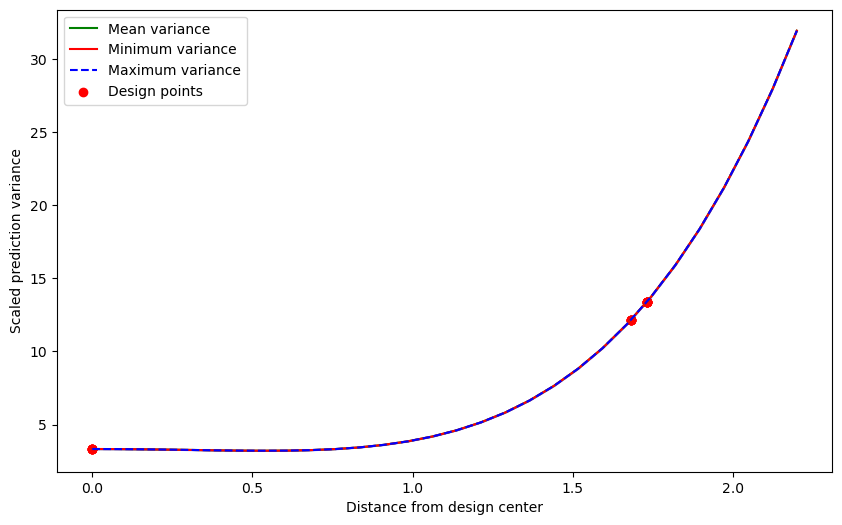

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

def calculate_model_matrix(design_matrix):
    """
    Calcula la matriz del modelo polinomial a partir de las componentes de primer grado, interacción y segundo grado.
    ---
    Parameters:
    design_matrix: np.array
        Array que contiene los valores del diseño CCD, se ha probado con matrices desde pyDOE3
    ---
    Returns:
    X: np.array
        Matriz del modelo polinomial
    """
    n_samples = design_matrix.shape[0]
    n_factors = design_matrix.shape[1]

    # Inicialización de los términos
    linear_terms = design_matrix
    squared_terms = design_matrix ** 2
    interaction_terms = []

    # Calculo de términos de interacción
    for i, j in combinations(range(n_factors), 2):
        interaction_terms.append(design_matrix[:, i] * design_matrix[:, j])

    # Combinación
    X = np.column_stack([
        np.ones(n_samples),  # Intercepto
        linear_terms,        # Terminos lineales
        squared_terms,       # Terminos cuadráticos
        *interaction_terms   # Terminos de interacción
    ])

    return X

def calculate_variance_function(X_transpose_X_inv, point, N):
    """
    Dado un punto point se calcula la varianza de la predicción dada la
    X_transpose_X_inv, y cantidad de puntos N
    ---
    Parameters:
    X_transpose_X_inv: np.array
        Corresponde a la operacion np.linalg.inv(X.T @ X). Se pasa
        Esta matriz dado a que es más eficiente al no tener que recalcularla
    point:
        Punto en donde evaluar la varianza
    N: número de puntos
    ---
    Returns:
    variance: float
        Varianza de la predicción
    ---
    Note:
    Se realiza un cambio de point a x dado a que se toma la evaluación del punto
    en la predicción. Para mayor información recomendamos leer:
    - https://cran.r-project.org/web/packages/vdg/vignettes/vdg.pdf
    - https://pdfs.semanticscholar.org/6aa7/dec94dc3b876dfb3e60dfa6d91f0a9ccf05e.pdf
    """
    # Calculamos el vector X
    x = np.array([1.0])  # Intercepto
    x = np.append(x, point)  # Término Lineal
    x = np.append(x, point ** 2)  # Término cuadrático

    # Término de interacción
    for i, j in combinations(range(len(point)), 2):
        x = np.append(x, point[i] * point[j])

    # Calculamos la varianza escalada
    variance = N * (x @ X_transpose_X_inv @ x)
    return variance

def random_hypersphere_points(n_points, n_dim):
    """
    Genera puntos random en una hipershepera de dimensión n_dim
    ---
    Parameters:
    n_points: int
        Cantidad de puntos a generar
    n_dim: int
        Dimensión de la hipershepera
    ---
    Returns:
    points: np.array
        Array con los puntos
    """


    points = np.random.normal(0, 1, (n_points, n_dim))
    points /= np.linalg.norm(points, axis=1)[:, np.newaxis]
    return points


def create_variance_dispersion_graph(design_matrix, n_radii=30, n_points_per_radius=10, max_distance = 2):
    """
    Dada la matriz de diseño y numeros de radio a evaluar se genera la VDG
    ---
    Parametros:
    design_matrix: np.array
        Matriz de diseño del experimento
    n_radii: int
        Cantidad de radios a evaluar
    n_points_per_radius: int
        Cantidad de puntos a generar en cada radio
    max_distance: float
        Distancia máxima a evaluar
    ---
    Returns:
    plt: matplotlib.pyplot.figure
        Figura con la VDG
    ---
    Note:
    Para mayor información recomendamos leer:
    - https://cran.r-project.org/web/packages/vdg/vignettes/vdg.pdf
    - https://pdfs.semanticscholar.org/6aa7/dec94dc3b876dfb3e60dfa6d91f0a9ccf05e.pdf
    """
    # Calculamos N
    N = design_matrix.shape[0]

    # Generamos el valor X_transpose_X_inv que será utilizado para el calculo
    # de la varianza
    X = calculate_model_matrix(design_matrix)
    X_transpose_X_inv = np.linalg.inv(X.T @ X)

    # Calculamos la distancia desde el centro
    distances = np.sqrt(np.sum(design_matrix ** 2, axis=1))
    if max_distance is None:
        max_distance = np.max(distances)

    # Generamos los radios para graficar
    r = np.linspace(0, max_distance * 1.1, n_radii)
    variances = []

    # Generamos puntos random en una hiperesfera unitaria que sera luego ajustado
    # a un radio r
    unit_sphere_points = random_hypersphere_points(n_points_per_radius, n_factors)

    # Calculamos el valor mínimo, promedio y máximo para cada radio
    for ri in r:
        if ri == 0:
            # Valor al centro
            v = calculate_variance_function(X_transpose_X_inv, np.zeros(n_factors), N)
            variances.append([v, v, v])
        else:
            # Escalamos la esfera unitaria y calculamos la varianza
            points = ri * unit_sphere_points
            v_list = [calculate_variance_function(X_transpose_X_inv, point, N) for point in points]
            variances.append([min(v_list),np.mean(v_list), max(v_list)])

    variances = np.array(variances)
    fig, ax = plt.subplots(figsize=(10, 6))
    # Creamos el plot
    ax.fill_between(r, variances[:, 0], variances[:, 2], alpha=0.3, color='blue')
    ax.plot(r, variances[:, 1], 'g-', label='Mean variance')
    ax.plot(r, variances[:, 0], 'r-', label='Minimum variance')
    ax.plot(r, variances[:, 1], 'b--', label='Maximum variance')

    # Calculamos la varianza en los puntos de diseño
    design_variances = [calculate_variance_function(X_transpose_X_inv, point, N)
                       for point in design_matrix]

    # Gráficamos los puntos de diseño
    ax.scatter(distances, design_variances, color='red', label='Design points')

    ax.set_xlabel('Distance from design center')
    ax.set_ylabel(f'Scaled prediction variance')
    ax.legend()

    return fig, ax

fig, ax = create_variance_dispersion_graph(design_matrix, n_radii=30, n_points_per_radius=10)
plt.show()



## Caso de Estudio: Optimización de la formulación de una mezcla de cemento para mejorar su viabilidad

In [5]:
# Diseño CCD de 3 factores

design_matrix = doe.ccdesign(3, center = (3,3), alpha = 'r')
design_new = np.zeros(design_matrix.shape)
# Para ser consistentes con el libro se realiza el siguiente cambio
design_new[:9, 0] = design_matrix[:9, 2]
design_new[:9, 1] = design_matrix[:9, 1]
design_new[:9, 2] = design_matrix[:9, 0]
design_new[9:, :] = design_matrix[9:, :]
### Response
response = [float(x) for x in [109.5, 120, 110.5,  124.5, 117.0, 130.0, 121.0,
                               132.0, 117.0, 117.0, 115.0, 109.5, 132.0, 120.0,
                               121.0, 115.0, 127.0, 116.0, 117.0, 117.0]]

df_cement = pd.DataFrame(design_new, columns = ['X_1', 'X_2', 'X_3'])
df_cement['WatCem'] = df_cement['X_1'] * 0.01 + 0.34
df_cement['BlackL'] = df_cement['X_2'] * 0.03 + 0.15
df_cement['SNF'] = df_cement['X_3'] * 0.02 + 0.1
df_cement['y'] = response
df_cement['Block'] = [1] * 11 + [2] * 9
df_cement

X_1       X_2       X_3    WatCem    BlackL       SNF      y  Block
0  -1.000000 -1.000000 -1.000000  0.330000  0.120000  0.080000  109.5      1
1   1.000000 -1.000000 -1.000000  0.350000  0.120000  0.080000  120.0      1
2  -1.000000  1.000000 -1.000000  0.330000  0.180000  0.080000  110.5      1
3   1.000000  1.000000 -1.000000  0.350000  0.180000  0.080000  124.5      1
4  -1.000000 -1.000000  1.000000  0.330000  0.120000  0.120000  117.0      1
5   1.000000 -1.000000  1.000000  0.350000  0.120000  0.120000  130.0      1
6  -1.000000  1.000000  1.000000  0.330000  0.180000  0.120000  121.0      1
7   1.000000  1.000000  1.000000  0.350000  0.180000  0.120000  132.0      1
8   0.000000  0.000000  0.000000  0.340000  0.150000  0.100000  117.0      1
9   0.000000  0.000000  0.000000  0.340000  0.150000  0.100000  117.0      1
10  0.000000  0.000000  0.000000  0.340000  0.150000  0.100000  115.0      1
11 -1.681793  0.000000  0.000000  0.323182  0.150000  0.100000  109.5      2
12  1.681793  0.000000  0.000000  0.356818  0.150000  0.100000  132.0      2
13  0.000000 -1.681793  0.000000  0.340000  0.099546  0.100000  120.0      2
14  0.000000  1.681793  0.000000  0.340000  0.200454  0.100000  121.0      2
15  0.000000  0.000000 -1.681793  0.340000  0.150000  0.066364  115.0      2
16  0.000000  0.000000  1.681793  0.340000  0.150000  0.133636  127.0      2
17  0.000000  0.000000  0.000000  0.340000  0.150000  0.100000  116.0      2
18  0.000000  0.000000  0.000000  0.340000  0.150000  0.100000  117.0      2
19  0.000000  0.000000  0.000000  0.340000  0.150000  0.100000  117.0      2

In [6]:

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools as it
def FirstO(*X):
    '''
    Pure First Order
    '''
    X = [x.values for x in X]
    return np.concatenate([X], axis = 1).T

def SecondO(*X):
    '''
    Pure Second Order
    '''
    X_aux = [x.values**2 for x in X]
    X_aux = np.concatenate([X_aux], axis = 1).T
    # get unique item
    X_unique = np.unique(X_aux, axis = 1)
    return X_unique


def TWI(*X):
    '''
    Two-way Interaction
    '''
    X = [x.values for x in X]
    interaction_terms = []

    # Calculo de términos de interacción
    for i, j in combinations(range(len(X)), 2):
        interaction_terms.append(X[i] * X[j])
    return np.concatenate([interaction_terms], axis = 1).T

only_block1 = df_cement.loc[df_cement['Block'] == 1]
only_block2 = df_cement.loc[df_cement['Block'] == 2]

model_cement_1 = ols(
    'y ~ FirstO(X_1, X_2, X_3) + SecondO(X_1, X_2, X_3) + TWI(X_1, X_2, X_3)',
    data = only_block1).fit()
### ANOVA

anova_cement_1 = anova_lm(model_cement_1, typ = 'II')
anova_cement_1

sum_sq   df          F    PR(>F)
FirstO(X_1, X_2, X_3)   468.093750  3.0  72.596123  0.002678
SecondO(X_1, X_2, X_3)   39.023674  1.0  18.156411  0.023707
TWI(X_1, X_2, X_3)        0.343750  3.0   0.053312  0.980965
Residual                  6.447917  3.0        NaN       NaN

In [7]:
# Analisis completo
def FirstOformula(*X):
    '''
    Pure First Order
    '''
    X = '+'.join(X)
    return X


def SecondOformula(*X):
    '''
    Pure Second Order
    '''
    X = '+'.join([f'np.power({x}, 2)' for x in X])
    return X

def TWIformula(*X):
    '''
    Two-way Interaction
    '''
    X_aux = []
    for i, j in combinations(range(len(X)), 2):
        X_aux.append(X[i] + ':' + X[j])
    X = '+'.join(X_aux)
    return X

formula = 'y ~ ' + FirstOformula('X_1', 'X_2', 'X_3') + ' + ' \
+ SecondOformula('X_1', 'X_2', 'X_3') + ' + ' + TWIformula('X_1', 'X_2', 'X_3')

model_cement_2 = ols(f'{formula} + Block', data = df_cement).fit()
print(model_cement_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     50.70
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           1.10e-06
Time:                        14:29:54   Log-Likelihood:                -25.662
No. Observations:                  20   AIC:                             73.32
Df Residuals:                       9   BIC:                             84.28
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          115.8982      1.047  

Dado que tenemos los puntos centrales, estos son replicados, por lo cual podemos estimar el 'error puro' de experimentación y obtener su varianza. La varianza no explicada puede usarse para hacer una prueba F para la bondad de ajuste.

In [8]:
import scipy.stats as stats
def lack_of_fit_test(linear_model):

    anova_lm_test = anova_lm(linear_model, type = 'II')
    residual_df = anova_lm_test.at['Residual','df']
    residual_ss = anova_lm_test.at['Residual','sum_sq']

    # Sum of squares of pure error
    unique_level = []
    count_level = []
    exog_variables = linear_model.model.exog
    for index, point in enumerate(exog_variables):

        if list(point) not in unique_level:
            unique_level.append(list(point))
            count_level.append([1, [index], point])
        else:
            count_level[unique_level.index(list(point))][0] += 1
            count_level[unique_level.index(list(point))][1].append(index)
    # print([co_lev[1] for co_lev in count_level])
    SS_LOF = 0
    coefficients = linear_model.params.values
    endog_values = linear_model.model.endog
    for u_lev in unique_level:
        n_i, indexes, val = count_level[unique_level.index(u_lev)]
        if len(indexes) == 1:
            indexes = indexes[0]
            exog_index = indexes
        else:
            exog_index = indexes[0]
        y_is = endog_values[indexes]
        mean_y_is = np.mean(y_is)
        exog_values = exog_variables[exog_index]
        prediction = coefficients @ exog_values
        SS_LOF += n_i * (mean_y_is - prediction) ** 2

    ###

    SS_PE = residual_ss - SS_LOF
    m = len(unique_level)
    p = len(coefficients)
    n = len(exog_variables)
    F_val_lof = (SS_LOF/(m - p))/(SS_PE/(n-m))

    lack_of_fit_test
    ###

    ### Valor P prueba

    p_val_lof = 1 - stats.f.cdf(F_val_lof, m - p, n - m)
    df_results = pd.DataFrame(np.zeros([3,4]), columns = ['df', 'sum_sq', 'F', 'p-value'])
    df_results.index = ['Residuals', 'Pure Error', 'Lack of Fit']

    df_results.at['Residuals', 'df'] = residual_df
    df_results.at['Residuals', 'sum_sq'] = residual_ss
    df_results.at['Residuals', 'F'] = np.nan
    df_results.at['Residuals', 'p-value'] = np.nan
    df_results.at['Pure Error', 'df'] = m - p
    df_results.at['Pure Error', 'sum_sq'] = SS_LOF
    df_results.at['Pure Error', 'F'] = np.nan
    df_results.at['Pure Error', 'p-value'] = np.nan
    df_results.at['Lack of Fit', 'df'] = n - m
    df_results.at['Lack of Fit', 'sum_sq'] = SS_PE
    df_results.at['Lack of Fit', 'F'] = F_val_lof
    df_results.at['Lack of Fit', 'p-value'] = p_val_lof

    return df_results

model_cement_3 = ols(
    'y ~ FirstO(X_1, X_2, X_3) + SecondO(X_1, X_2, X_3) + TWI(X_1, X_2, X_3) + Block',
    data = df_cement).fit()
### ANOVA

anova_cement_3 = anova_lm(model_cement_3, typ = 'II')
display(anova_cement_3)
lack_of_fit_test(model_cement_3)

sum_sq   df           F        PR(>F)
FirstO(X_1, X_2, X_3)   785.601468  3.0  154.625365  4.646214e-08
SecondO(X_1, X_2, X_3)   72.610732  3.0   14.291548  9.042300e-04
TWI(X_1, X_2, X_3)        0.343750  3.0    0.067658  9.757346e-01
Block                     0.789811  1.0    0.466361  5.118597e-01
Residual                 15.242030  9.0         NaN           NaN

df     sum_sq         F   p-value
Residuals    9.0  15.242030       NaN       NaN
Pure Error   5.0  11.908696       NaN       NaN
Lack of Fit  4.0   3.333333  2.858087  0.165418

In [9]:
# Modelo redudcido
formula = 'y~' + FirstOformula('X_1', 'X_2','X_3') +'+'+ SecondOformula('X_1', 'X_2','X_3')
model_cement_red = ols(formula, data = df_cement).fit()
print(model_cement_red.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     113.4
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           1.83e-10
Time:                        14:29:54   Log-Likelihood:                -26.379
No. Observations:                  20   AIC:                             66.76
Df Residuals:                      13   BIC:                             73.73
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          116.5144      0.458  

In [10]:
model_cement_anova = ols('y ~ FirstO(X_1, X_3) + SecondO(X_1, X_3)', data = df_cement).fit()
print('----------------')
print('ANOVA and Lack of Fit Test')
display(anova_lm(model_cement_anova))
lack_of_fit_test(model_cement_anova)

----------------
ANOVA and Lack of Fit Test


df      sum_sq     mean_sq           F        PR(>F)
FirstO(X_1, X_3)    2.0  772.878211  386.439106  106.911918  1.331757e-09
SecondO(X_1, X_3)   2.0   46.703450   23.351725    6.460469  9.466937e-03
Residual           15.0   54.218339    3.614556         NaN           NaN

df     sum_sq         F   p-value
Residuals    15.0  54.218339       NaN       NaN
Pure Error    4.0   5.593339       NaN       NaN
Lack of Fit  11.0  48.625000  0.316333  0.861198

Y ahora evaluamos los resudios de modelo.

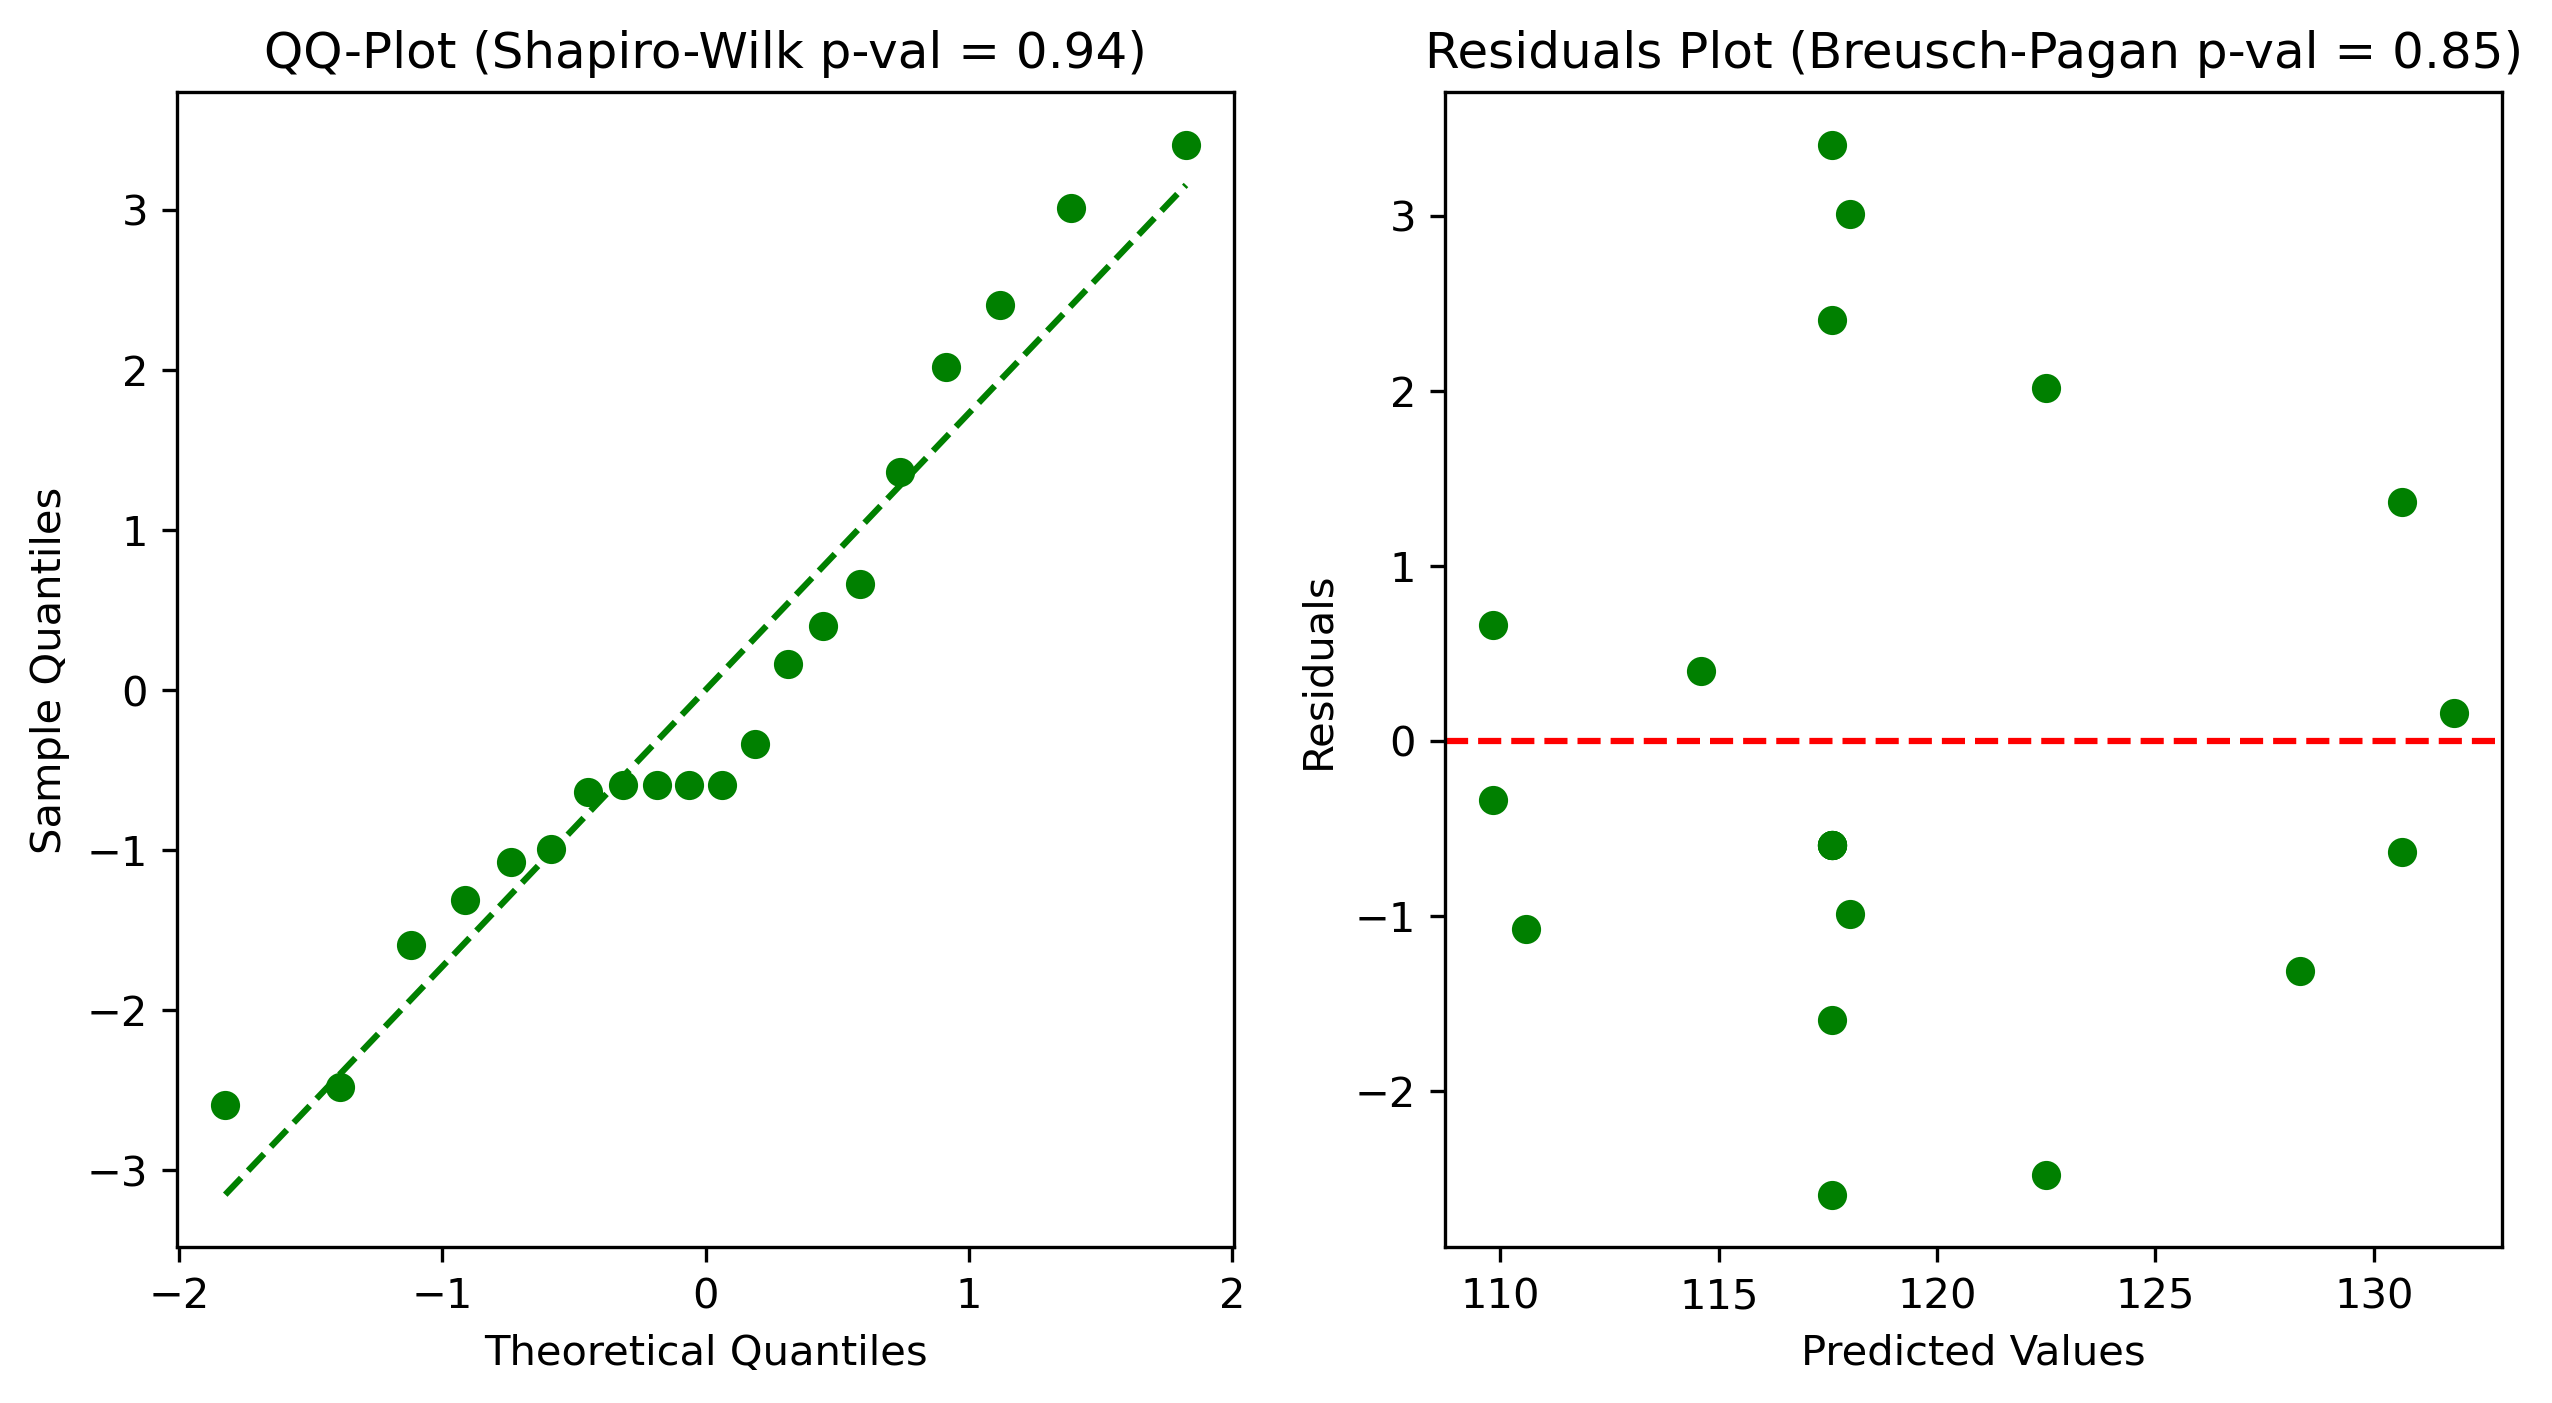

In [11]:
from statsmodels.stats.diagnostic import het_breuschpagan
residuals = model_cement_anova.resid
fig, ax = plt.subplots(1,2, dpi = 300, figsize = (10, 5))
(osm, osr), (slope, intercept, r) = stats.probplot(residuals)
ax[0].scatter(osm, osr, color = 'green')
ax[0].plot(osm, osm*slope + intercept, color = 'green' , linestyle = '--')
shapiro_p, _ = stats.shapiro(residuals)
ax[0].set_title(f'QQ-Plot (Shapiro-Wilk p-val = {shapiro_p:0.2f})')
ax[0].set_xlabel('Theoretical Quantiles')
ax[0].set_ylabel('Sample Quantiles')

# residuals
predicted = model_cement_anova.predict()
ax[1].scatter(predicted, residuals, color = 'green')
ax[1].axhline(y = 0, color = 'red', linestyle = '--')

bg_test = het_breuschpagan(residuals, model_cement_anova.model.exog)
ax[1].set_title(f'Residuals Plot (Breusch-Pagan p-val = {bg_test[1]:0.2f})')
ax[1].set_xlabel('Predicted Values')
ax[1].set_ylabel('Residuals')
plt.show()

# Diseño Box-Behnken (BBD)

Para crear un diseño Box-Behnken podemos usar el mismo paquete que utilizamos anteriormente.

In [12]:
n_factors = 3
design_matrix = doe.bbdesign(n_factors, # numero de factores
                             center = 4) # numero de puntos centrales
print(design_matrix)

[[-1. -1.  0.]
 [-1.  1.  0.]
 [ 1. -1.  0.]
 [ 1.  1.  0.]
 [-1.  0. -1.]
 [-1.  0.  1.]
 [ 1.  0. -1.]
 [ 1.  0.  1.]
 [ 0. -1. -1.]
 [ 0. -1.  1.]
 [ 0.  1. -1.]
 [ 0.  1.  1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


## Caso de Estudio: Lanzamiento de Catapulta

In [13]:
A = [ 4, 8, 4, 8, 4, 8, 4, 8, 6, 6, 6, 6, 6, 6, 6]
B = [10, 10, 20, 20, 15, 15, 15, 15, 10, 20, 10, 20, 15, 15, 15]
C = [2.5, 2.5, 2.5, 2.5, 2, 2, 3, 3, 2, 2, 3, 3, 2.5, 2.5, 2.5]
y = [33, 85, 86, 113, 75, 105, 40, 89, 83, 108, 49, 101, 88, 91, 91]

df_catapulta = pd.DataFrame({'A': A, 'B': B, 'C': C, 'y': y})
df_catapulta['A_coded'] = (df_catapulta['A'] - (df_catapulta['A'].min() + df_catapulta['A'].max())/2)/ ((df_catapulta['A'].max() - df_catapulta['A'].min())/2)
df_catapulta['B_coded'] = (df_catapulta['B'] - (df_catapulta['B'].min() + df_catapulta['B'].max())/2)/ ((df_catapulta['B'].max() - df_catapulta['B'].min())/2)
df_catapulta['C_coded'] = (df_catapulta['C'] - (df_catapulta['C'].min() + df_catapulta['C'].max())/2)/ ((df_catapulta['C'].max() - df_catapulta['C'].min())/2)
df_catapulta

A   B    C    y  A_coded  B_coded  C_coded
0   4  10  2.5   33     -1.0     -1.0      0.0
1   8  10  2.5   85      1.0     -1.0      0.0
2   4  20  2.5   86     -1.0      1.0      0.0
3   8  20  2.5  113      1.0      1.0      0.0
4   4  15  2.0   75     -1.0      0.0     -1.0
5   8  15  2.0  105      1.0      0.0     -1.0
6   4  15  3.0   40     -1.0      0.0      1.0
7   8  15  3.0   89      1.0      0.0      1.0
8   6  10  2.0   83      0.0     -1.0     -1.0
9   6  20  2.0  108      0.0      1.0     -1.0
10  6  10  3.0   49      0.0     -1.0      1.0
11  6  20  3.0  101      0.0      1.0      1.0
12  6  15  2.5   88      0.0      0.0      0.0
13  6  15  2.5   91      0.0      0.0      0.0
14  6  15  2.5   91      0.0      0.0      0.0

In [14]:
# Regression Lineal y Anova
formula = 'y ~' + FirstOformula('A_coded', 'B_coded', 'C_coded')+ \
'+'+ TWIformula('A_coded', 'B_coded', 'C_coded') +'+'+ SecondOformula('A_coded', 'B_coded', 'C_coded')


ols_catapulta = ols(formula, data = df_catapulta).fit()
print(ols_catapulta.summary())
lm_catapulta_anova = ols('y~FirstO(A_coded, B_coded, C_coded) + TWI(A_coded, B_coded, C_coded)+ SecondO(A_coded, B_coded, C_coded)'
, data = df_catapulta).fit()
anova_catapulta = anova_lm(lm_catapulta_anova)
display(anova_catapulta)
lack_of_fit_test(lm_catapulta_anova)



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     218.9
Date:                Thu, 05 Jun 2025   Prob (F-statistic):           5.96e-06
Time:                        14:29:54   Log-Likelihood:                -23.627
No. Observations:                  15   AIC:                             67.25
Df Residuals:                       5   BIC:                             74.33
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               90.0000 

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  res = hypotest_fun_out(*samples, **kwds)


df       sum_sq      mean_sq           F  \
FirstO(A_coded, B_coded, C_coded)   3.0  7299.000000  2433.000000  593.414634   
TWI(A_coded, B_coded, C_coded)      3.0   428.750000   142.916667   34.857724   
SecondO(A_coded, B_coded, C_coded)  3.0   351.483333   117.161111   28.575881   
Residual                            5.0    20.500000     4.100000         NaN   

                                          PR(>F)  
FirstO(A_coded, B_coded, C_coded)   8.448437e-07  
TWI(A_coded, B_coded, C_coded)      8.912375e-04  
SecondO(A_coded, B_coded, C_coded)  1.423565e-03  
Residual                                     NaN

df  sum_sq         F   p-value
Residuals    5.0    20.5       NaN       NaN
Pure Error   3.0    14.5       NaN       NaN
Lack of Fit  2.0     6.0  1.611111  0.405131

# Punto Óptimo: Análisis Gráfico

A diferencia de `R`, en python no existe una forma única de poder crear gráficos de contorno y superficies de respuesta, para poder generarlos es necesario entender que representan cada uno de estos gráficos y poder representarlos usando `matplotlib`.

---
Referencia y Ejemplos:
- https://www.geeksforgeeks.org/surface-plots-and-contour-plots-in-python/
- https://matplotlib.org/stable/gallery/mplot3d/surface3d.html
- https://www.geeksforgeeks.org/contour-plots/

## Gráficos de Contorno

Una gráfica de contorno representa una superficie 3D trazando líneas que conectan puntos con valores z comunes a lo largo de un corte. Por ejemplo, puede utilizar una gráfica de contorno para visualizar la altura de una superficie en dos o tres dimensiones.

En nuestro caso, queremos saber como reacciones la variable respuesta, variar dos variables a manteniendo una constante.

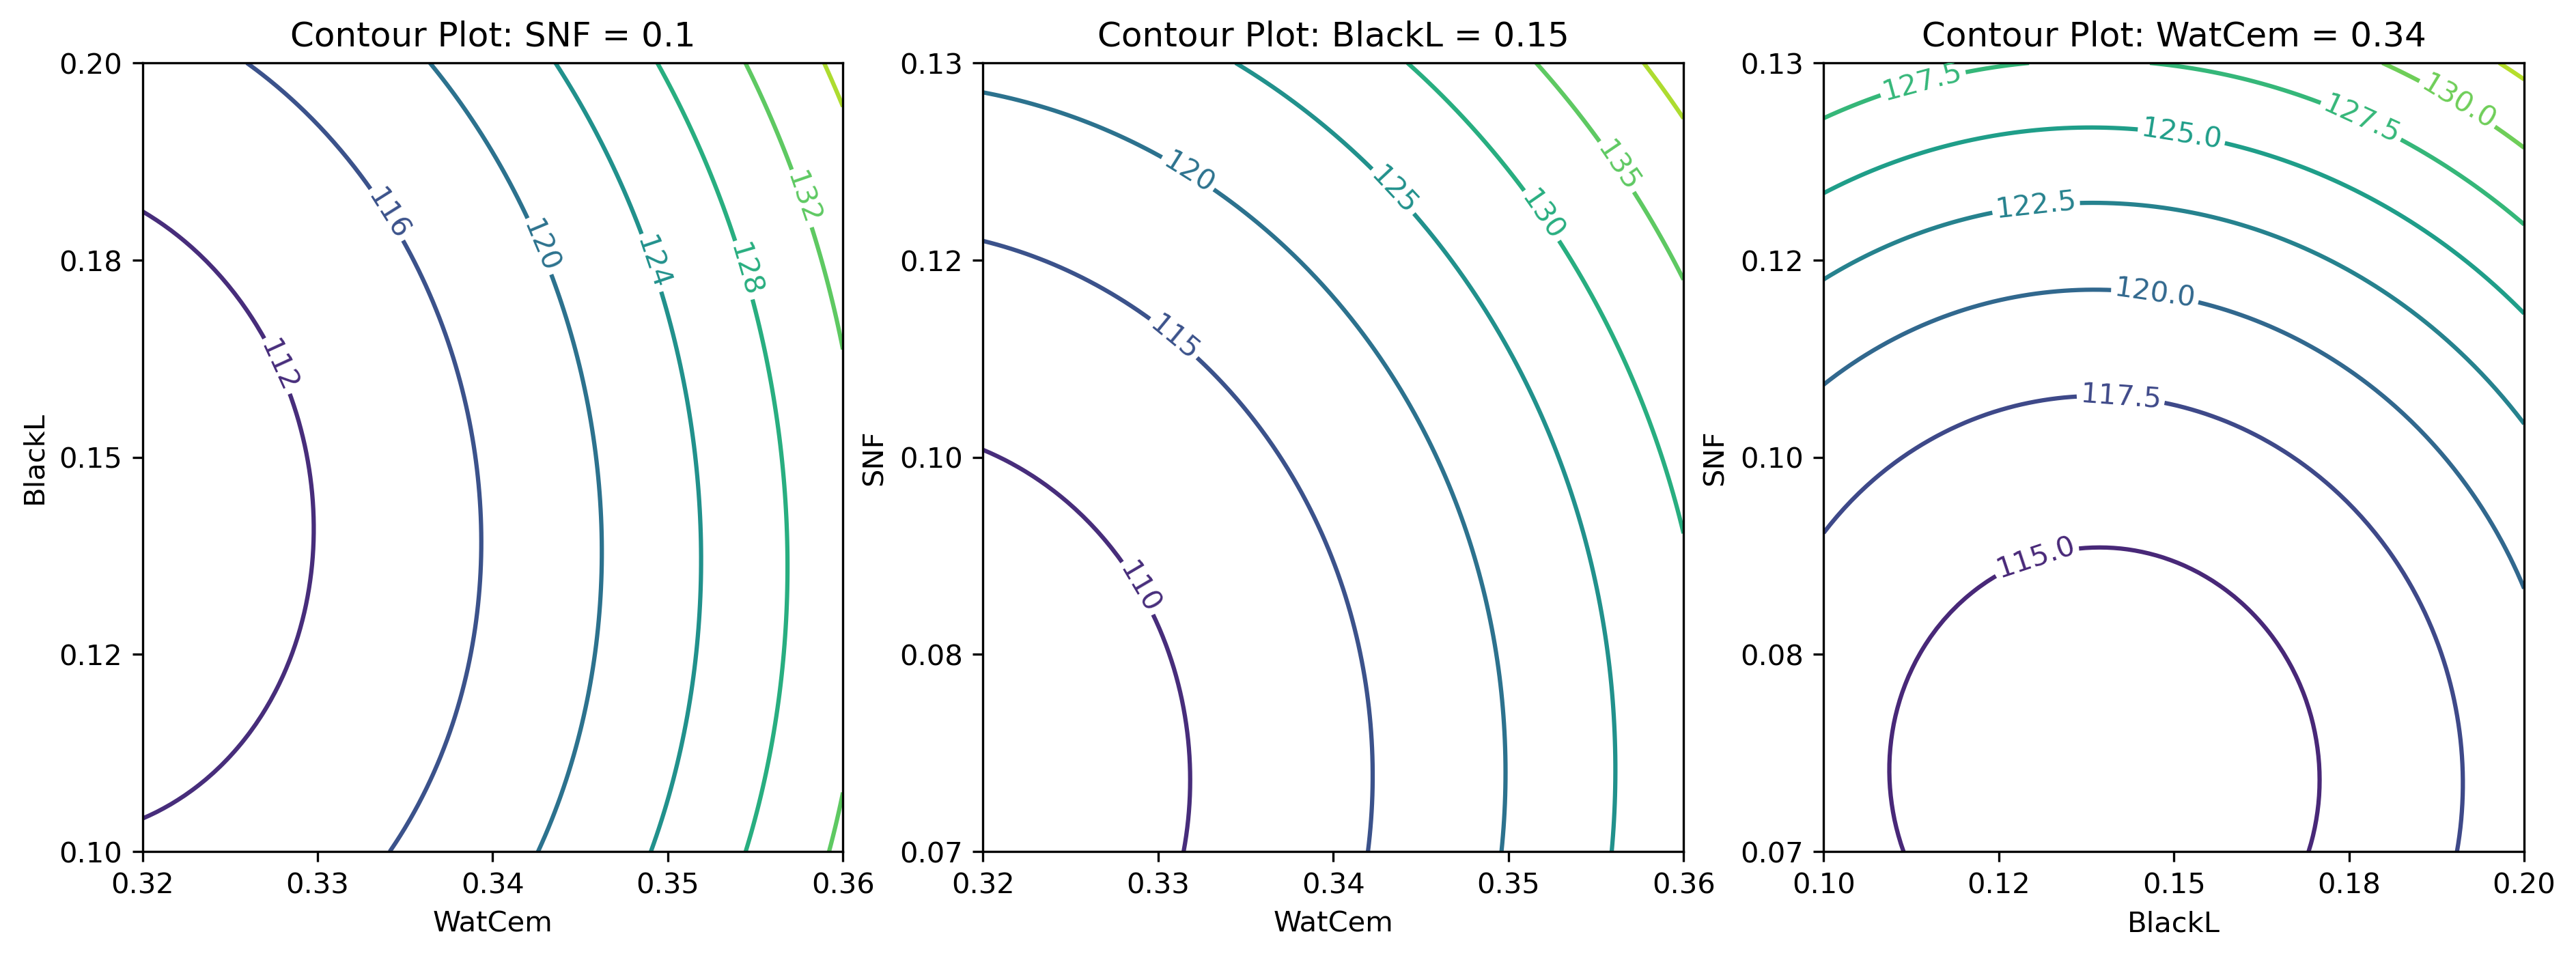

In [15]:
# Para el modelo de CO
from sklearn.preprocessing import MinMaxScaler

# modelo
from copy import deepcopy
# Modificamos las variables para que pueda ser aplicado el modelo cuadratico
def cuadratic_model_variables(data_matrix, blocks = []):
    rows, columns = data_matrix.shape
    intercept = np.ones(rows)
    linear_terms = data_matrix
    squared_terms = data_matrix ** 2
    interaction_terms = []

    # Calculo de términos de interacción
    for i, j in combinations(range(columns), 2):
        interaction_terms.append(data_matrix[:, i] * data_matrix[:, j])

    if len(blocks) == 0:
        X = np.column_stack([intercept, linear_terms,  *interaction_terms,squared_terms,])
    else:
        X = np.column_stack([intercept, linear_terms, *interaction_terms, squared_terms, blocks])
    return X


def get_coded_funct(df, coded, real):

    coded_data = df[coded]
    real_data = df[real]
    relations = {i:j for i,j in zip(coded_data, real_data)}
    minus1 = relations[-1]
    plus1 = relations[1]
    def functr(x):
        return x * (plus1 - minus1)/2 + (plus1 + minus1)/2
    return functr

# Ignoramos el termino de bloque

# fig, ax = plt.subplots(1,3 ,figsize = (10, 5))
val_list = ['X_1', 'X_2', 'X_3']

### Forma para des-codificar los datos

codes = {
    'X_1': get_coded_funct(df_cement, 'X_1', 'WatCem'),
    'X_2': get_coded_funct(df_cement, 'X_2', 'BlackL'),
    'X_3': get_coded_funct(df_cement, 'X_3', 'SNF')
}

codification_names = {
    'X_1': 'WatCem',
    'X_2': 'BlackL',
    'X_3': 'SNF'
}
# Generamos el modelo
formula = 'y~' + '+' + FirstOformula('X_1', 'X_2', 'X_3')+ \
'+'+ TWIformula('X_1', 'X_2', 'X_3') +'+'+ SecondOformula('X_1', 'X_2', 'X_3')

model_contour_cement = ols(formula, data = df_cement).fit()

fig, ax = plt.subplots(1,3 ,figsize = (15, 5), dpi = 300)

# Graficamos
for i, (x,y) in enumerate(it.combinations(val_list, 2)):
    aux_list = deepcopy(val_list)
    data_x = df_cement[x].values
    data_y = df_cement[y].values
    aux_list.remove(x)
    aux_list.remove(y)
    # valor constante
    name_z = aux_list[0]
    data_z = np.round(np.mean(df_cement[aux_list].values),10)

    x_plot = np.linspace(np.min(data_x), np.max(data_x), 100)
    y_plot = np.linspace(np.min(data_y), np.max(data_y), 100)
    X, Y = np.meshgrid(x_plot, y_plot)
    Z = np.full(X.shape, data_z)

    data_list = [0,0,0]
    data_list[val_list.index(x)] = X.ravel()
    data_list[val_list.index(y)] = Y.ravel()
    data_list[val_list.index(name_z)] = Z.ravel()

    X_data = cuadratic_model_variables(np.column_stack(data_list))


    response = model_contour_cement.params @ X_data.T

    response = np.reshape(response, X.shape)
    CS = ax[i].contour(X, Y, response)
    ax[i].clabel(CS, fontsize=10)
    ax[i].set_title(f'Contour Plot: {codification_names[name_z]} = {codes[name_z](data_z)}')
    x_ticks = np.linspace(np.min(data_x), np.max(data_x), 5)
    y_ticks = np.linspace(np.min(data_y), np.max(data_y), 5)
    ax[i].set_xticks(x_ticks)
    ax[i].set_yticks(y_ticks)
    # change to real vals
    ax[i].set_xticklabels([f'{i:.2f}' for i in codes[x](x_ticks)])
    ax[i].set_yticklabels([f'{i:.2f}' for i in codes[y](y_ticks)])
    # ax[i].set_xlabel(x)
    ax[i].set_xlabel(codification_names[x])
    ax[i].set_ylabel(codification_names[y])




## Superficie de Respuesta

Los gráficos de contorno son proyecciones en 2D de una superficie de respuesta, la cual es un objeto 3D. Así, podemos ver como una variable (generalmente en el eje Z) cambia en base a dos en el espacio tri-dimensional.

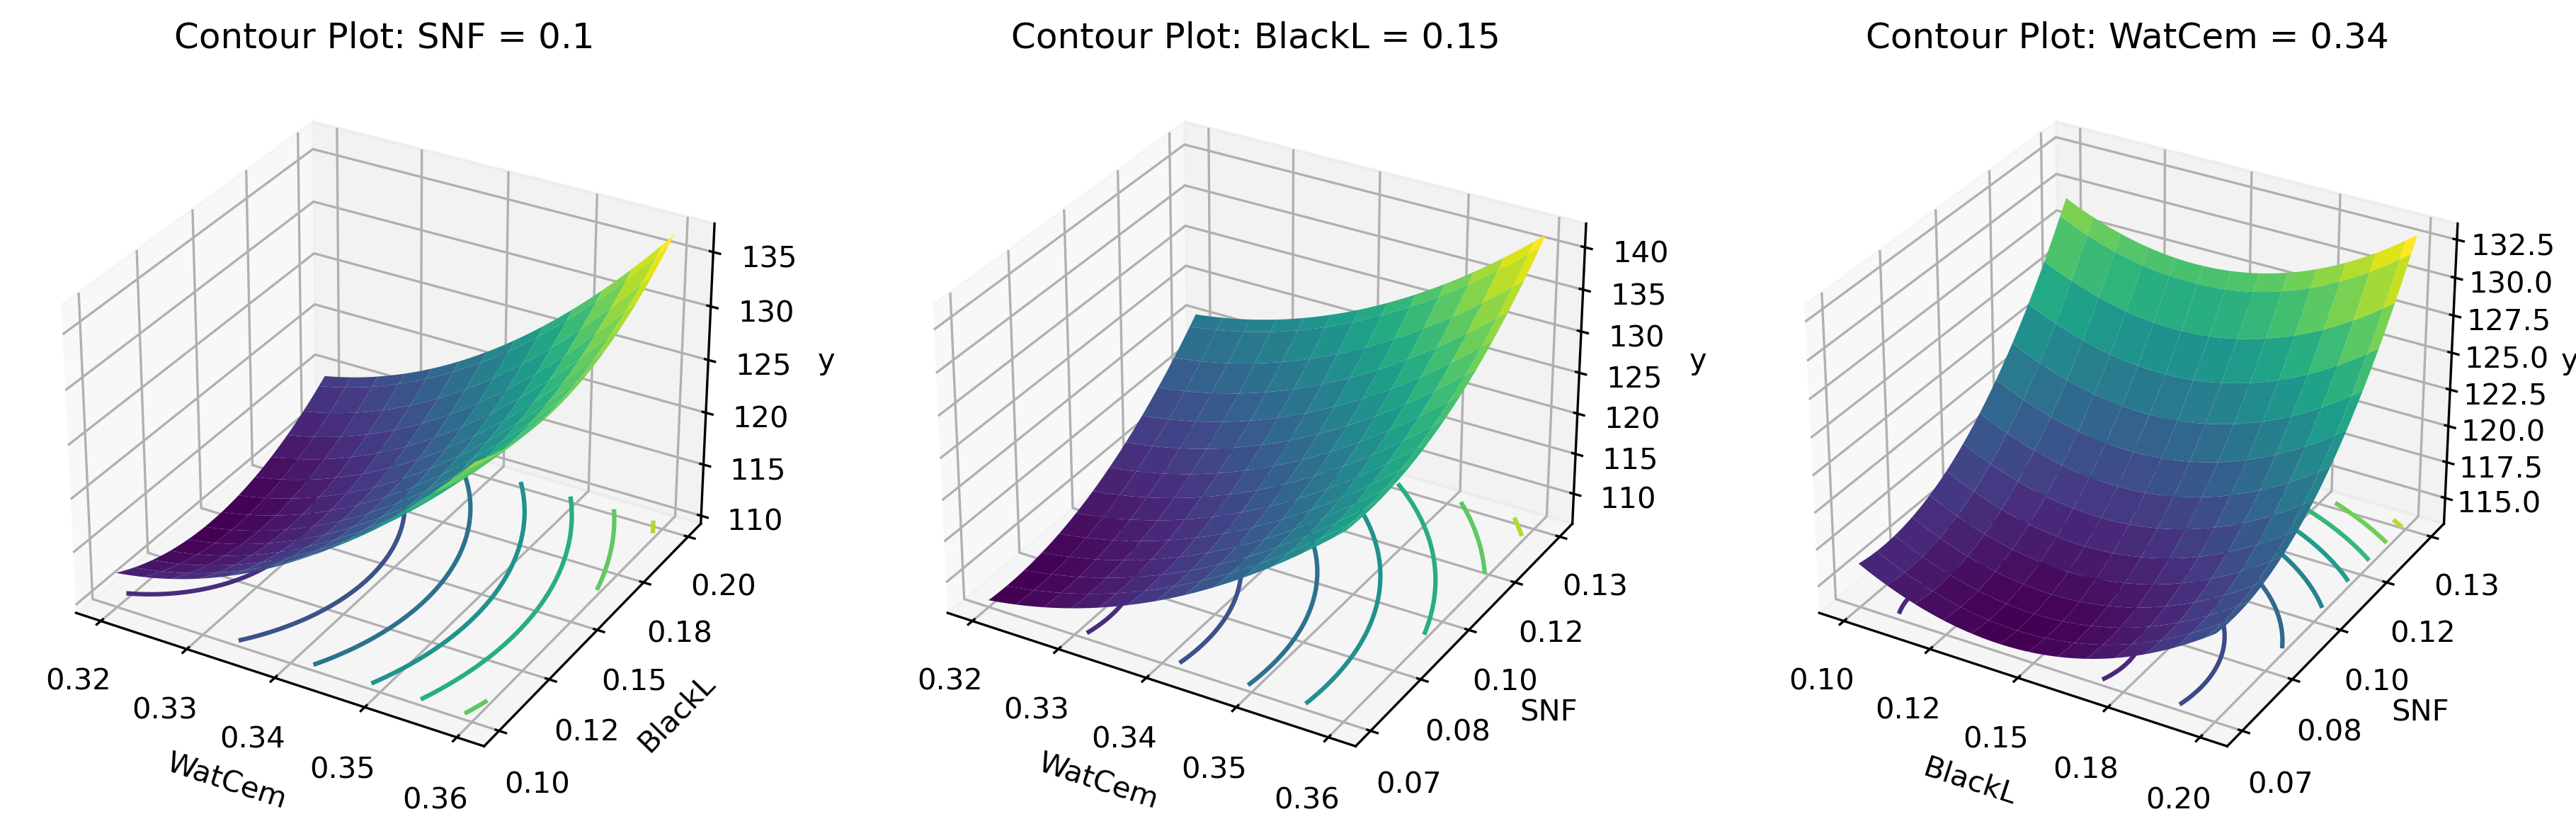

In [16]:
# Para el modelo de CO
from sklearn.preprocessing import MinMaxScaler

# modelo
from copy import deepcopy
# Modificamos las variables para que pueda ser aplicado el modelo cuadratico
def cuadratic_model_variables(data_matrix, blocks = []):
    rows, columns = data_matrix.shape
    intercept = np.ones(rows)
    linear_terms = data_matrix
    squared_terms = data_matrix ** 2
    interaction_terms = []

    # Calculo de términos de interacción
    for i, j in combinations(range(columns), 2):
        interaction_terms.append(data_matrix[:, i] * data_matrix[:, j])

    if len(blocks) == 0:
        X = np.column_stack([intercept, linear_terms,  *interaction_terms,squared_terms,])
    else:
        X = np.column_stack([intercept, linear_terms, *interaction_terms, squared_terms, blocks])
    return X


def get_coded_funct(df, coded, real):

    coded_data = df[coded]
    real_data = df[real]
    relations = {i:j for i,j in zip(coded_data, real_data)}
    minus1 = relations[-1]
    plus1 = relations[1]
    def functr(x):
        return x * (plus1 - minus1)/2 + (plus1 + minus1)/2
    return functr

# Ignoramos el termino de bloque

# fig, ax = plt.subplots(1,3 ,figsize = (10, 5))
val_list = ['X_1', 'X_2', 'X_3']

### Forma para des-codificar los datos

codes = {
    'X_1': get_coded_funct(df_cement, 'X_1', 'WatCem'),
    'X_2': get_coded_funct(df_cement, 'X_2', 'BlackL'),
    'X_3': get_coded_funct(df_cement, 'X_3', 'SNF')
}

codification_names = {
    'X_1': 'WatCem',
    'X_2': 'BlackL',
    'X_3': 'SNF'
}
# Generamos el modelo
formula = 'y~' + '+' + FirstOformula('X_1', 'X_2', 'X_3')+ \
'+'+ TWIformula('X_1', 'X_2', 'X_3') +'+'+ SecondOformula('X_1', 'X_2', 'X_3')
model_contour_cement = ols(formula, data = df_cement).fit()


fig = plt.figure(dpi = 300, figsize = (15,5))
# Graficamos
for i, (x,y) in enumerate(it.combinations(val_list, 2)):
    aux_list = deepcopy(val_list)
    data_x = df_cement[x].values
    data_y = df_cement[y].values
    aux_list.remove(x)
    aux_list.remove(y)
    # valor constante
    name_z = aux_list[0]
    data_z = np.round(np.mean(df_cement[aux_list].values),10)

    x_plot = np.linspace(np.min(data_x), np.max(data_x), 100)
    y_plot = np.linspace(np.min(data_y), np.max(data_y), 100)
    X, Y = np.meshgrid(x_plot, y_plot)
    Z = np.full(X.shape, data_z)

    data_list = [0,0,0]
    data_list[val_list.index(x)] = X.ravel()
    data_list[val_list.index(y)] = Y.ravel()
    data_list[val_list.index(name_z)] = Z.ravel()

    X_data = cuadratic_model_variables(np.column_stack(data_list))


    response = model_contour_cement.params @ X_data.T

    response = np.reshape(response, X.shape)
    ax = fig.add_subplot(1,3, i+1, projection = '3d')
    CS = ax.plot_surface(X, Y, response, cmap = 'viridis', lw=1, rstride=8, cstride=8,
                alpha=1)
    ax.contour(X, Y, response, zdir='z', offset=np.min(response), cmap='viridis')
    ax.clabel(CS, fontsize=10)
    ax.set_title(f'Contour Plot: {codification_names[name_z]} = {codes[name_z](data_z)}')
    x_ticks = np.linspace(np.min(data_x), np.max(data_x), 5)
    y_ticks = np.linspace(np.min(data_y), np.max(data_y), 5)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    # change to real vals
    ax.set_xticklabels([f'{i:.2f}' for i in codes[x](x_ticks)])
    ax.set_yticklabels([f'{i:.2f}' for i in codes[y](y_ticks)])
    # ax[i].set_xlabel(x)
    ax.set_xlabel(codification_names[x])
    ax.set_ylabel(codification_names[y])
    ax.set_zlabel('y')


### Evaluación en diseño BB

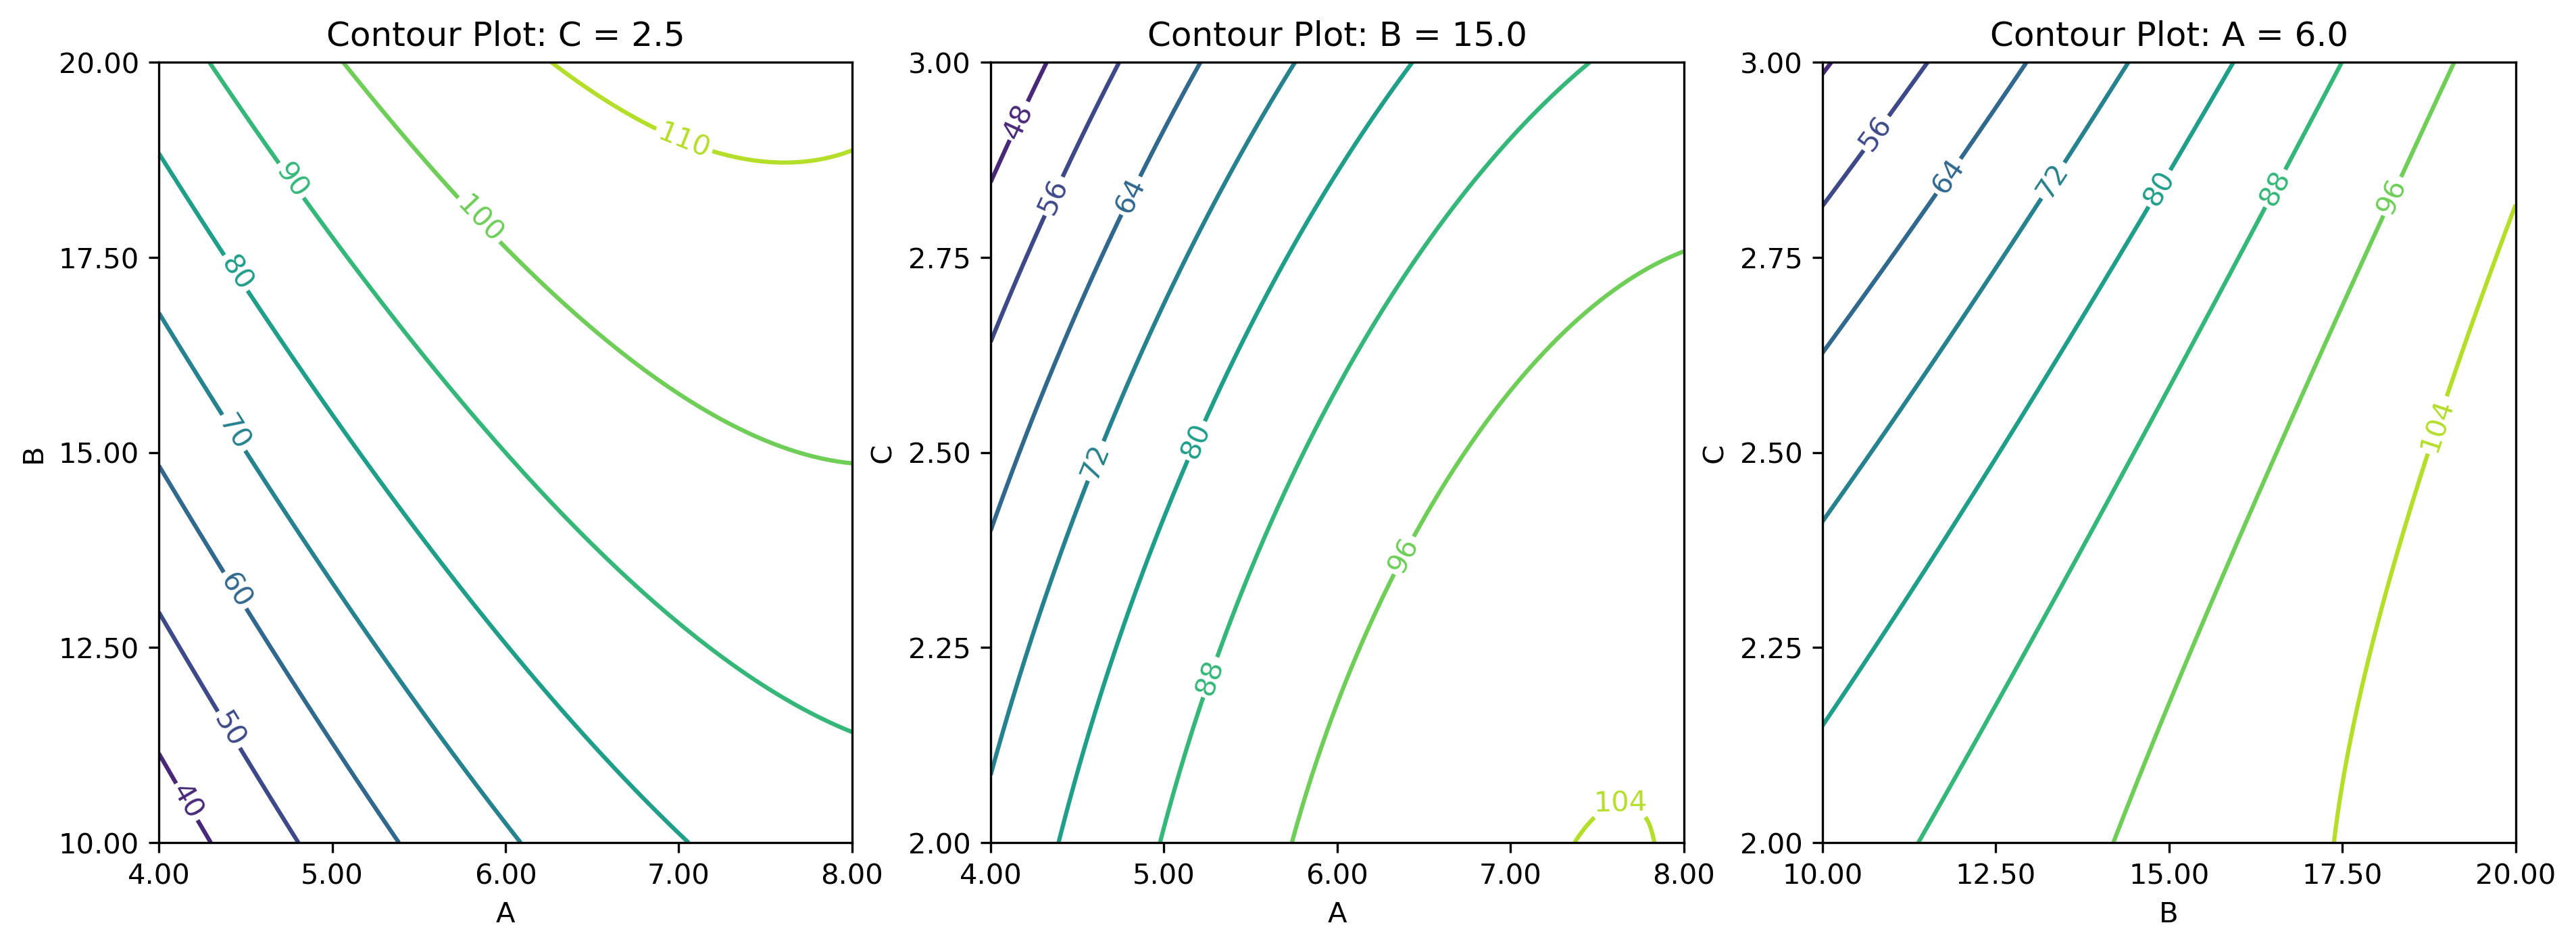

In [17]:
# Para el modelo de CO
from sklearn.preprocessing import MinMaxScaler

# modelo
from copy import deepcopy
# Modificamos las variables para que pueda ser aplicado el modelo cuadratico
def cuadratic_model_variables(data_matrix, blocks = []):
    rows, columns = data_matrix.shape
    intercept = np.ones(rows)
    linear_terms = data_matrix
    squared_terms = data_matrix ** 2
    interaction_terms = []

    # Calculo de términos de interacción
    for i, j in combinations(range(columns), 2):
        interaction_terms.append(data_matrix[:, i] * data_matrix[:, j])

    if len(blocks) == 0:
        X = np.column_stack([intercept, linear_terms,  *interaction_terms,squared_terms,])
    else:
        X = np.column_stack([intercept, linear_terms, *interaction_terms, squared_terms, blocks])
    return X


def get_coded_funct(df, coded, real):

    coded_data = df[coded]
    real_data = df[real]
    relations = {i:j for i,j in zip(coded_data, real_data)}
    minus1 = relations[-1]
    plus1 = relations[1]
    def functr(x):
        return x * (plus1 - minus1)/2 + (plus1 + minus1)/2
    return functr

# Ignoramos el termino de bloque

# fig, ax = plt.subplots(1,3 ,figsize = (10, 5))
val_list = ['A_coded', 'B_coded', 'C_coded']

### Forma para des-codificar los datos

codes = {
    'A_coded': get_coded_funct(df_catapulta, 'A_coded', 'A'),
    'B_coded': get_coded_funct(df_catapulta, 'B_coded', 'B'),
    'C_coded': get_coded_funct(df_catapulta, 'C_coded', 'C')
}

codification_names = {
    'A_coded': 'A',
    'B_coded': 'B',
    'C_coded': 'C'
}
# Generamos el modelo

formula = 'y~'+ '+' + FirstOformula('A_coded', 'B_coded', 'C_coded')+ \
'+'+ TWIformula('A_coded', 'B_coded', 'C_coded') +'+'+ SecondOformula('A_coded', 'B_coded', 'C_coded')

model_contour_cata = ols(formula, data = df_catapulta).fit()

fig, ax = plt.subplots(1,3 ,figsize = (15, 5), dpi = 300)

# Graficamos
for i, (x,y) in enumerate(it.combinations(val_list, 2)):
    aux_list = deepcopy(val_list)
    data_x = df_catapulta[x].values
    data_y = df_catapulta[y].values
    aux_list.remove(x)
    aux_list.remove(y)
    # valor constante
    name_z = aux_list[0]
    data_z = np.round(np.mean(df_catapulta[aux_list].values),10)

    x_plot = np.linspace(np.min(data_x), np.max(data_x), 100)
    y_plot = np.linspace(np.min(data_y), np.max(data_y), 100)
    X, Y = np.meshgrid(x_plot, y_plot)
    Z = np.full(X.shape, data_z)

    data_list = [0,0,0]
    data_list[val_list.index(x)] = X.ravel()
    data_list[val_list.index(y)] = Y.ravel()
    data_list[val_list.index(name_z)] = Z.ravel()

    X_data = cuadratic_model_variables(np.column_stack(data_list))


    response = model_contour_cata.params @ X_data.T

    response = np.reshape(response, X.shape)
    CS = ax[i].contour(X, Y, response)
    ax[i].clabel(CS, fontsize=10)
    ax[i].set_title(f'Contour Plot: {codification_names[name_z]} = {codes[name_z](data_z)}')
    x_ticks = np.linspace(np.min(data_x), np.max(data_x), 5)
    y_ticks = np.linspace(np.min(data_y), np.max(data_y), 5)
    ax[i].set_xticks(x_ticks)
    ax[i].set_yticks(y_ticks)
    # change to real vals
    ax[i].set_xticklabels([f'{i:.2f}' for i in codes[x](x_ticks)])
    ax[i].set_yticklabels([f'{i:.2f}' for i in codes[y](y_ticks)])
    # ax[i].set_xlabel(x)
    ax[i].set_xlabel(codification_names[x])
    ax[i].set_ylabel(codification_names[y])



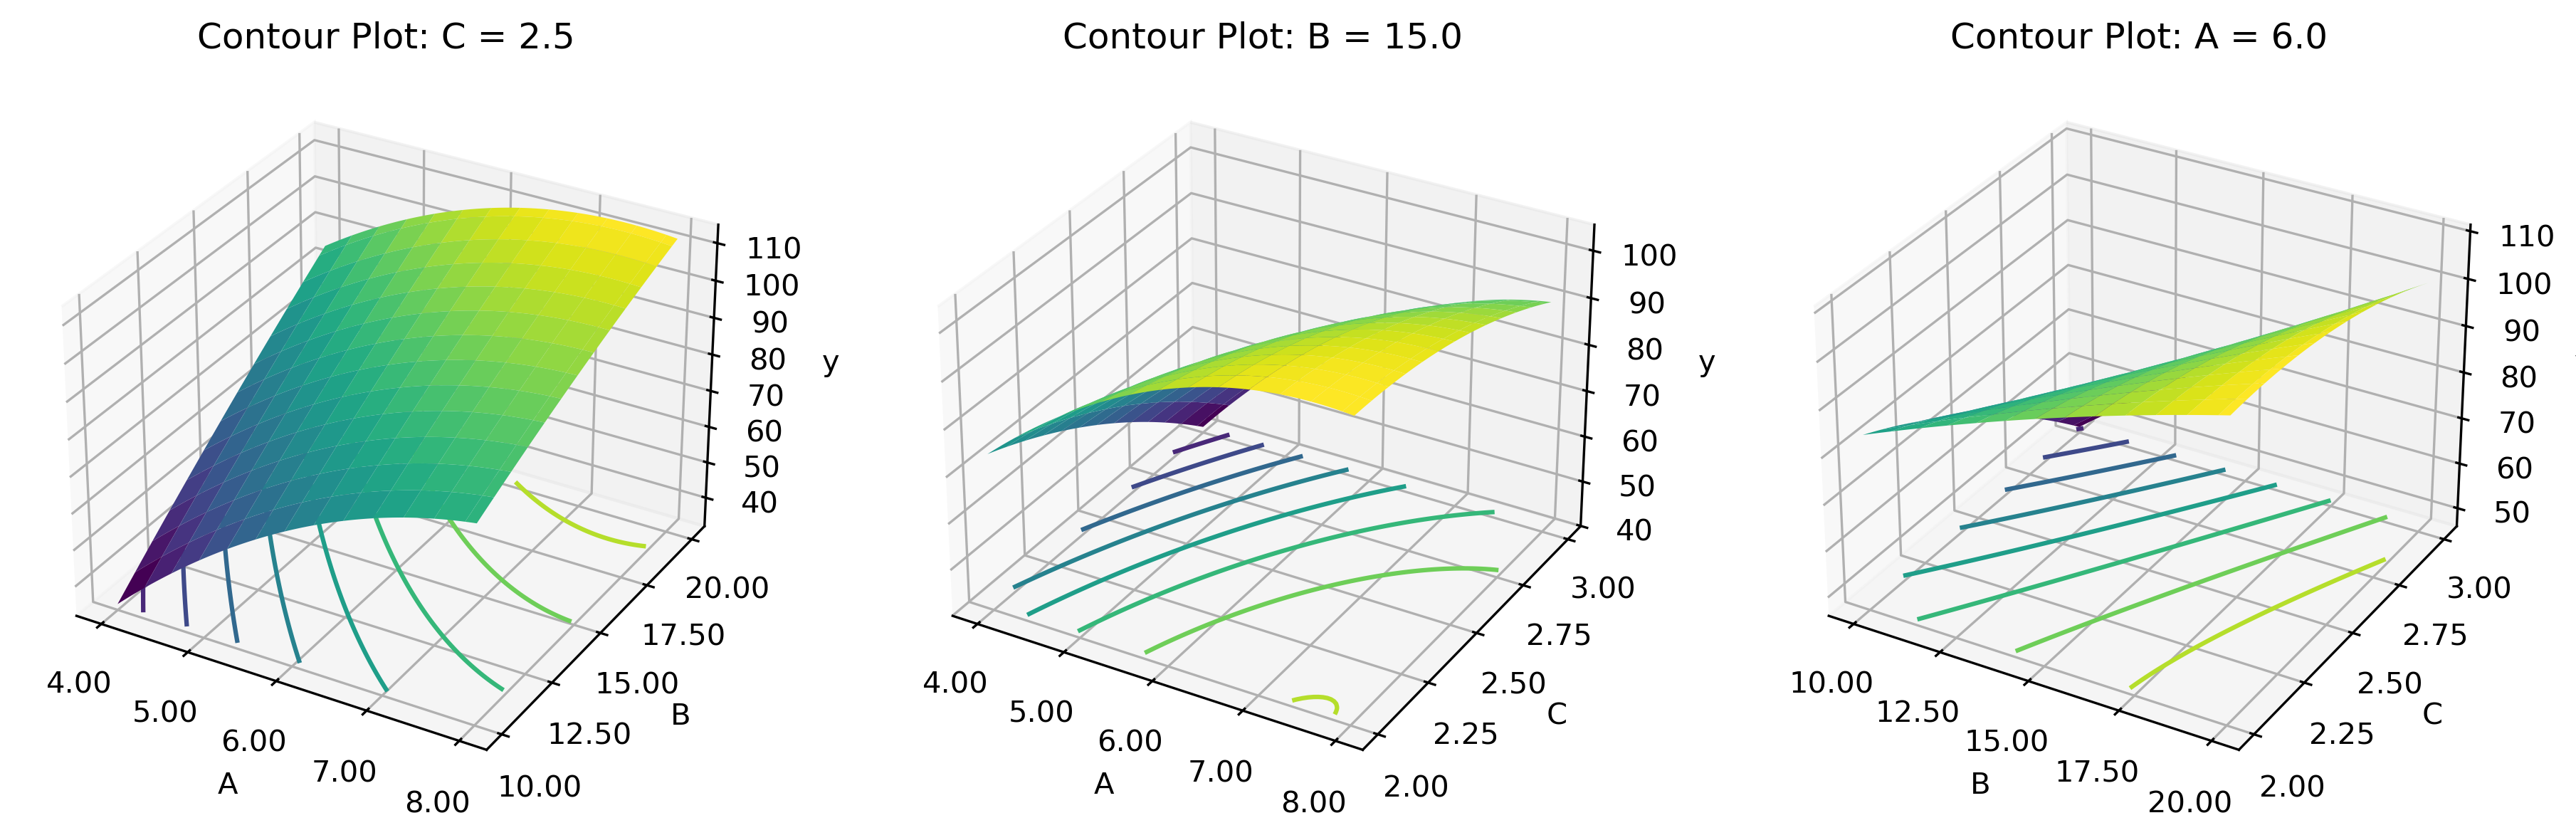

In [18]:
# Para el modelo de CO
from sklearn.preprocessing import MinMaxScaler

# modelo
from copy import deepcopy
# Modificamos las variables para que pueda ser aplicado el modelo cuadratico
def cuadratic_model_variables(data_matrix, blocks = []):
    rows, columns = data_matrix.shape
    intercept = np.ones(rows)
    linear_terms = data_matrix
    squared_terms = data_matrix ** 2
    interaction_terms = []

    # Calculo de términos de interacción
    for i, j in combinations(range(columns), 2):
        interaction_terms.append(data_matrix[:, i] * data_matrix[:, j])

    if len(blocks) == 0:
        X = np.column_stack([intercept, linear_terms,  *interaction_terms,squared_terms,])
    else:
        X = np.column_stack([intercept, linear_terms, *interaction_terms, squared_terms, blocks])
    return X


def get_coded_funct(df, coded, real):

    coded_data = df[coded]
    real_data = df[real]
    relations = {i:j for i,j in zip(coded_data, real_data)}
    minus1 = relations[-1]
    plus1 = relations[1]
    def functr(x):
        return x * (plus1 - minus1)/2 + (plus1 + minus1)/2
    return functr

# Ignoramos el termino de bloque

# fig, ax = plt.subplots(1,3 ,figsize = (10, 5))
val_list = ['A_coded', 'B_coded', 'C_coded']

### Forma para des-codificar los datos

codes = {
    'A_coded': get_coded_funct(df_catapulta, 'A_coded', 'A'),
    'B_coded': get_coded_funct(df_catapulta, 'B_coded', 'B'),
    'C_coded': get_coded_funct(df_catapulta, 'C_coded', 'C')
}

codification_names = {
    'A_coded': 'A',
    'B_coded': 'B',
    'C_coded': 'C'
}
# Generamos el modelo
formula = 'y~' + '+' + FirstOformula('A_coded', 'B_coded', 'C_coded')+ \
'+'+ TWIformula('A_coded', 'B_coded', 'C_coded') +'+'+ SecondOformula('A_coded', 'B_coded', 'C_coded')
model_contour_cata = ols(formula, data = df_catapulta).fit()

fig = plt.figure(dpi = 300, figsize = (15,5))
# Graficamos
for i, (x,y) in enumerate(it.combinations(val_list, 2)):
    aux_list = deepcopy(val_list)
    data_x = df_catapulta[x].values
    data_y = df_catapulta[y].values
    aux_list.remove(x)
    aux_list.remove(y)
    # valor constante
    name_z = aux_list[0]
    data_z = np.round(np.mean(df_catapulta[aux_list].values),10)

    x_plot = np.linspace(np.min(data_x), np.max(data_x), 100)
    y_plot = np.linspace(np.min(data_y), np.max(data_y), 100)
    X, Y = np.meshgrid(x_plot, y_plot)
    Z = np.full(X.shape, data_z)

    data_list = [0,0,0]
    data_list[val_list.index(x)] = X.ravel()
    data_list[val_list.index(y)] = Y.ravel()
    data_list[val_list.index(name_z)] = Z.ravel()

    X_data = cuadratic_model_variables(np.column_stack(data_list))


    response = model_contour_cata.params @ X_data.T

    response = np.reshape(response, X.shape)
    ax = fig.add_subplot(1,3, i+1, projection = '3d')
    # ax.view_init( azim=10)
    CS = ax.plot_surface(X, Y, response, cmap = 'viridis', lw=1, rstride=8, cstride=8,
                alpha=1)
    ax.contour(X, Y, response, zdir='z', offset=np.min(response), cmap='viridis')
    ax.clabel(CS, fontsize=10)
    ax.set_title(f'Contour Plot: {codification_names[name_z]} = {codes[name_z](data_z)}')
    x_ticks = np.linspace(np.min(data_x), np.max(data_x), 5)
    y_ticks = np.linspace(np.min(data_y), np.max(data_y), 5)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    # change to real vals
    ax.set_xticklabels([f'{i:.2f}' for i in codes[x](x_ticks)])
    ax.set_yticklabels([f'{i:.2f}' for i in codes[y](y_ticks)])
    # ax[i].set_xlabel(x)
    ax.set_xlabel(codification_names[x])
    ax.set_ylabel(codification_names[y])
    ax.set_zlabel('y')


# Punto Óptimo: Análisis Canónico

En el análisis canónico, se determinan los valores en base a la derivada de la ecuación cuadrática que define el modelo. Dado el modelo, es posible encontrar puntos máximos y mínimos fuera del rango experimental, pero hay que tener precaución con la extrapolación del modelo.

Nos damos cuenta que en este caso, el punto mínimo en este sístema está fuera del rango de los datos.

Veamos que pasa si agragamos límites al sistema:

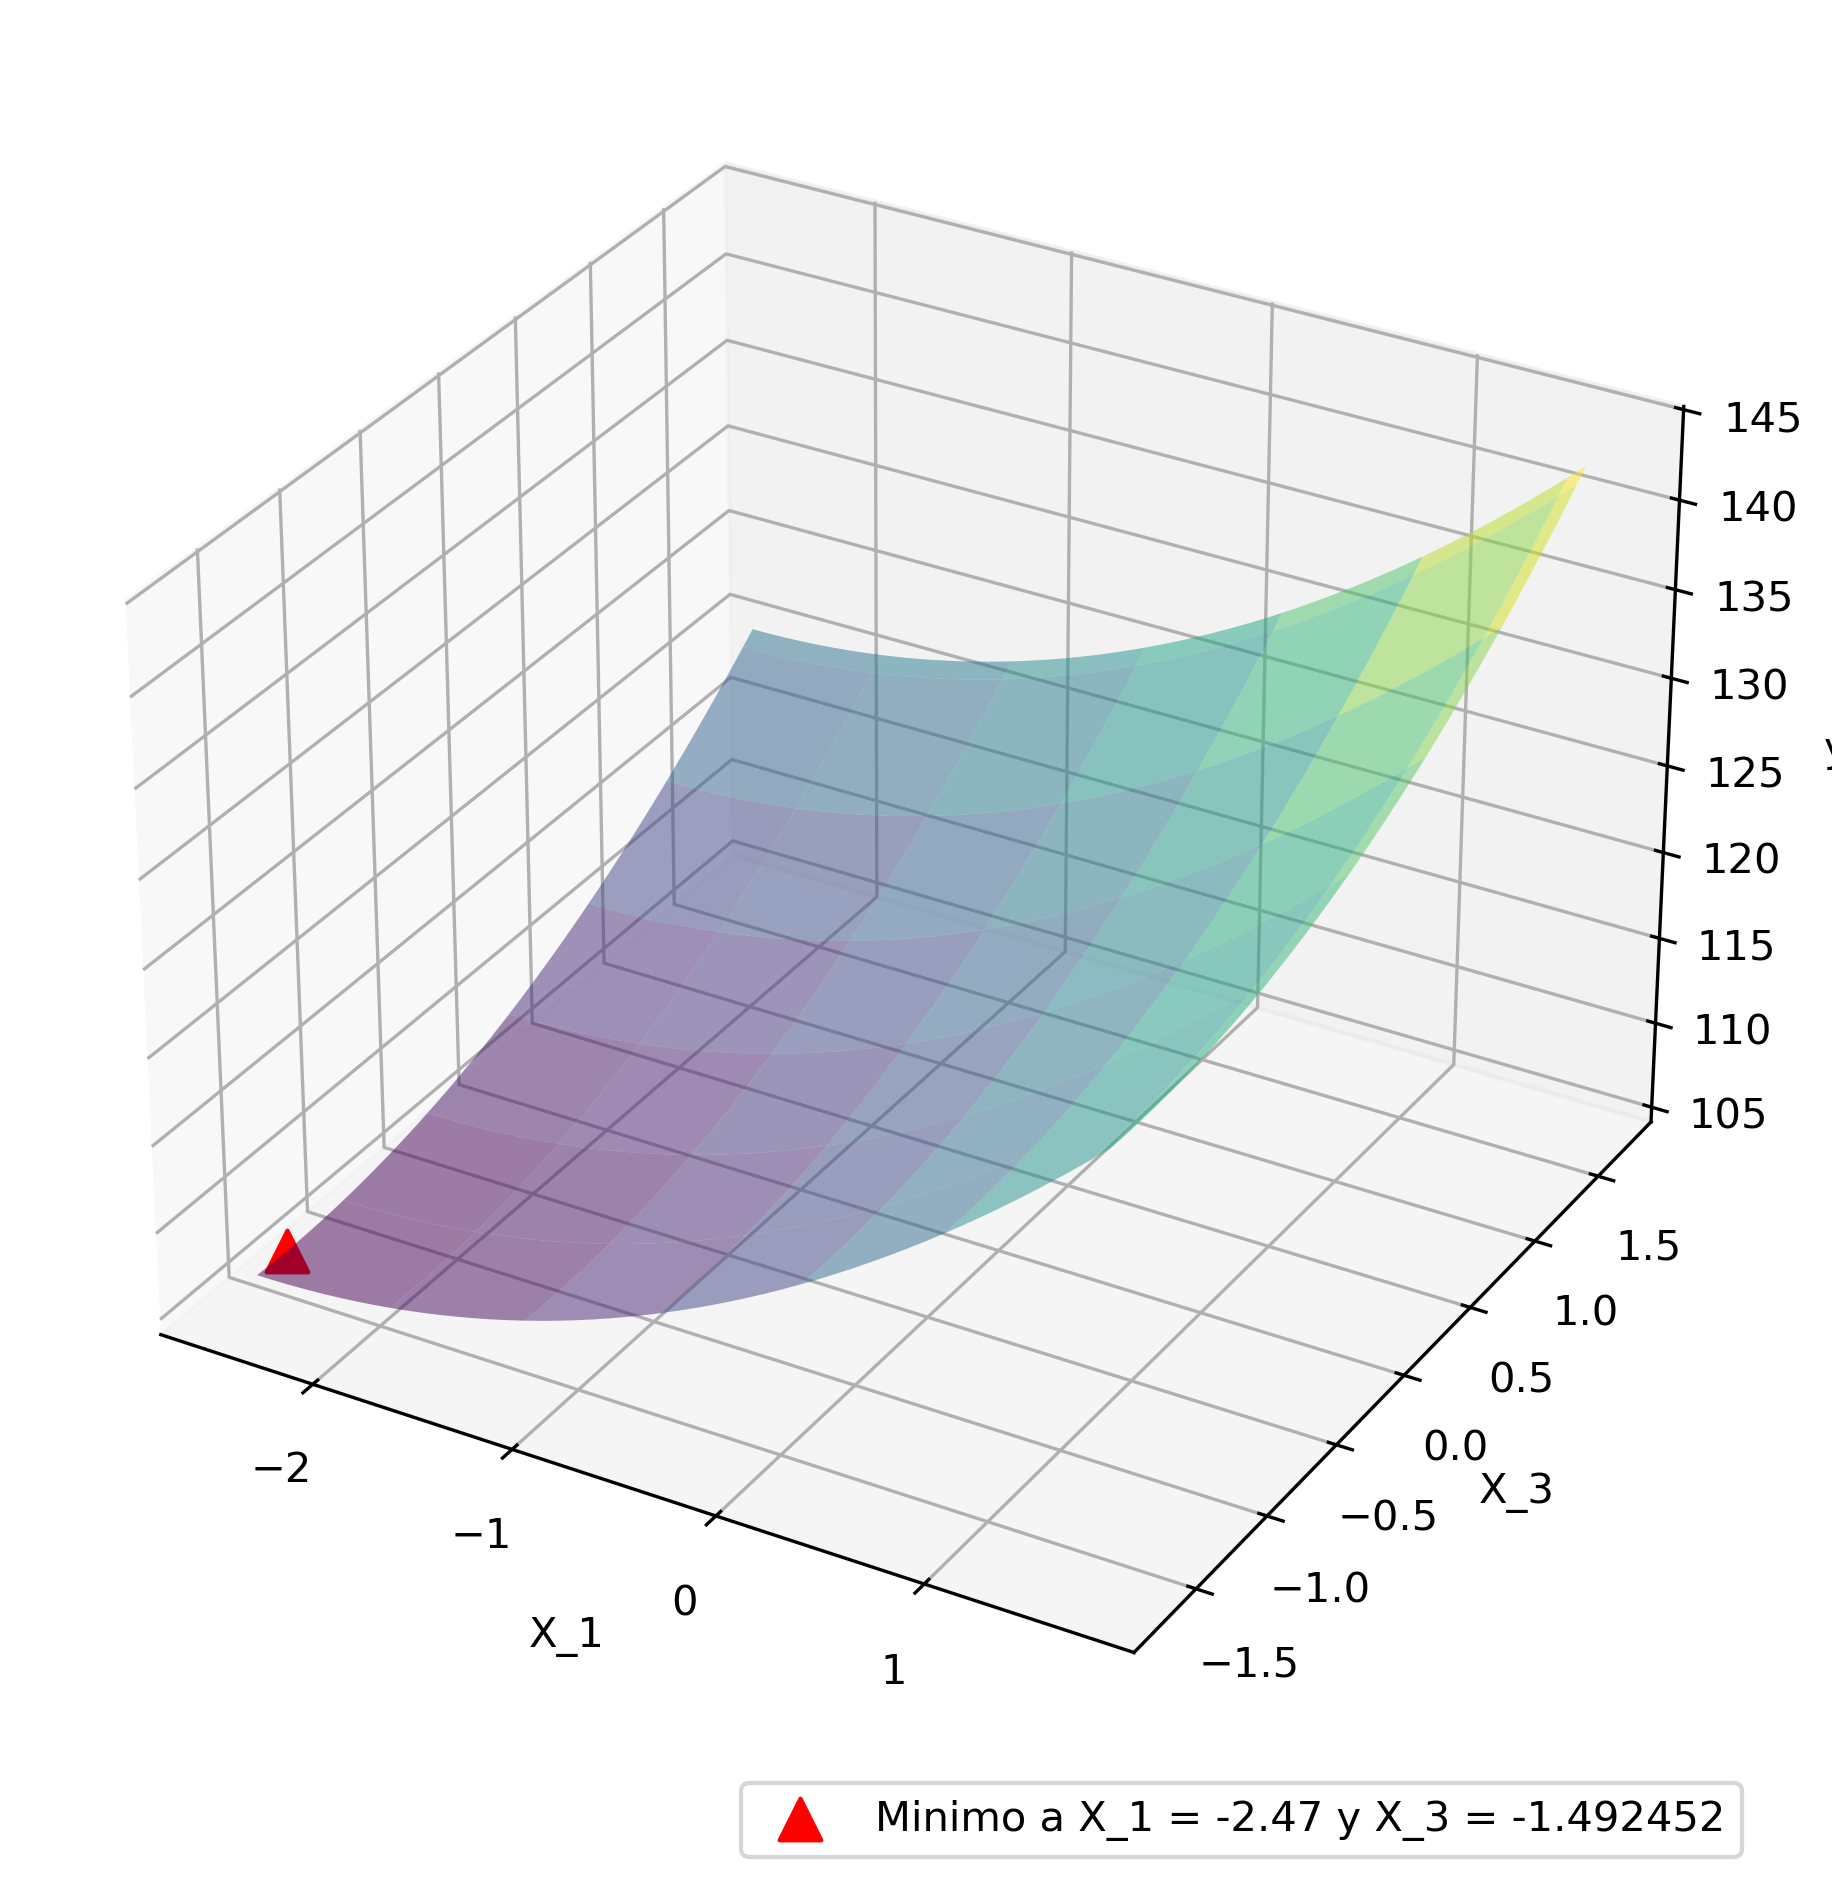

In [19]:
# Modelo CCD
from scipy.optimize import minimize

# generamos el modelo reducido para cemento basado en el modelo reducido
formula = 'y~'+'+'+ FirstOformula('X_1', 'X_3')+'+'+ SecondOformula('X_1', 'X_3')

ols_red_cem = ols(formula, data = df_cement).fit()

def modeloCCD_red(X, params):

    return params[0] + params[1] * X[0] + params[2] * X[1] + params[3] * X[0] * X[0] + params[4] * X[1] * X[1]

# boundaries = [
#     (np.min(df_cement['X_1']), np.max(df_cement['X_1'])),
#     (np.min(df_cement['X_3']), np.max(df_cement['X_3']))
# ]

res_min = minimize(
    modeloCCD_red, [0,0], args = (ols_red_cem.params.values), method = 'Nelder-Mead',
    # bounds = boundaries
)

### Plot in surface plot

x_axis = np.linspace(min(np.min(df_cement['X_1']), res_min.x[0]), np.max(df_cement['X_1']), 50)
y_axis = np.linspace(min(np.min(df_cement['X_3']), res_min.x[1]), np.max(df_cement['X_3']), 50)
X, Y = np.meshgrid(x_axis, y_axis)
Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j] = modeloCCD_red([X[i,j], Y[i,j]], ols_red_cem.params.values)

fig = plt.figure(dpi = 300, figsize = (7.5,7.5))
ax = fig.add_subplot(1,1, 1, projection = '3d')
ax.plot_surface(X, Y, Z, cmap = 'viridis', lw=1, rstride=8, cstride=8,
                alpha=0.5, zorder = 0)
ax.scatter(res_min.x[0], res_min.x[1], res_min.fun, color = 'red',
           label = f'Minimo a X_1 = {res_min.x[0]:.2f} y X_3 = {res_min.x[1]:2f}', zorder = 3, s = 100,
           marker = '^')
ax.set_xlabel('X_1')
ax.set_ylabel('X_3')
ax.set_zlabel('y')
ax.legend(bbox_to_anchor = (1,0))
plt.show()

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: -2.6686439020106925e+102
             x: [-1.973e+50 -4.867e+50  3.784e+50]
           nit: 299
          nfev: 600
 final_simplex: (array([[-1.973e+50, -4.867e+50,  3.784e+50],
                       [-1.297e+50, -3.199e+50,  2.488e+50],
                       [-8.525e+49, -2.103e+50,  1.635e+50],
                       [-5.603e+49, -1.382e+50,  1.075e+50]]), array([-2.669e+102, -1.153e+102, -4.981e+101, -2.152e+101]))


/var/folders/zv/p838yyl57rb2tlk802d5y2hh0000gn/T/ipykernel_27846/3487006124.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i,j] = modelobb(np.array([X[i,j], Y[i,j], 0]), ols_bb.params.values)


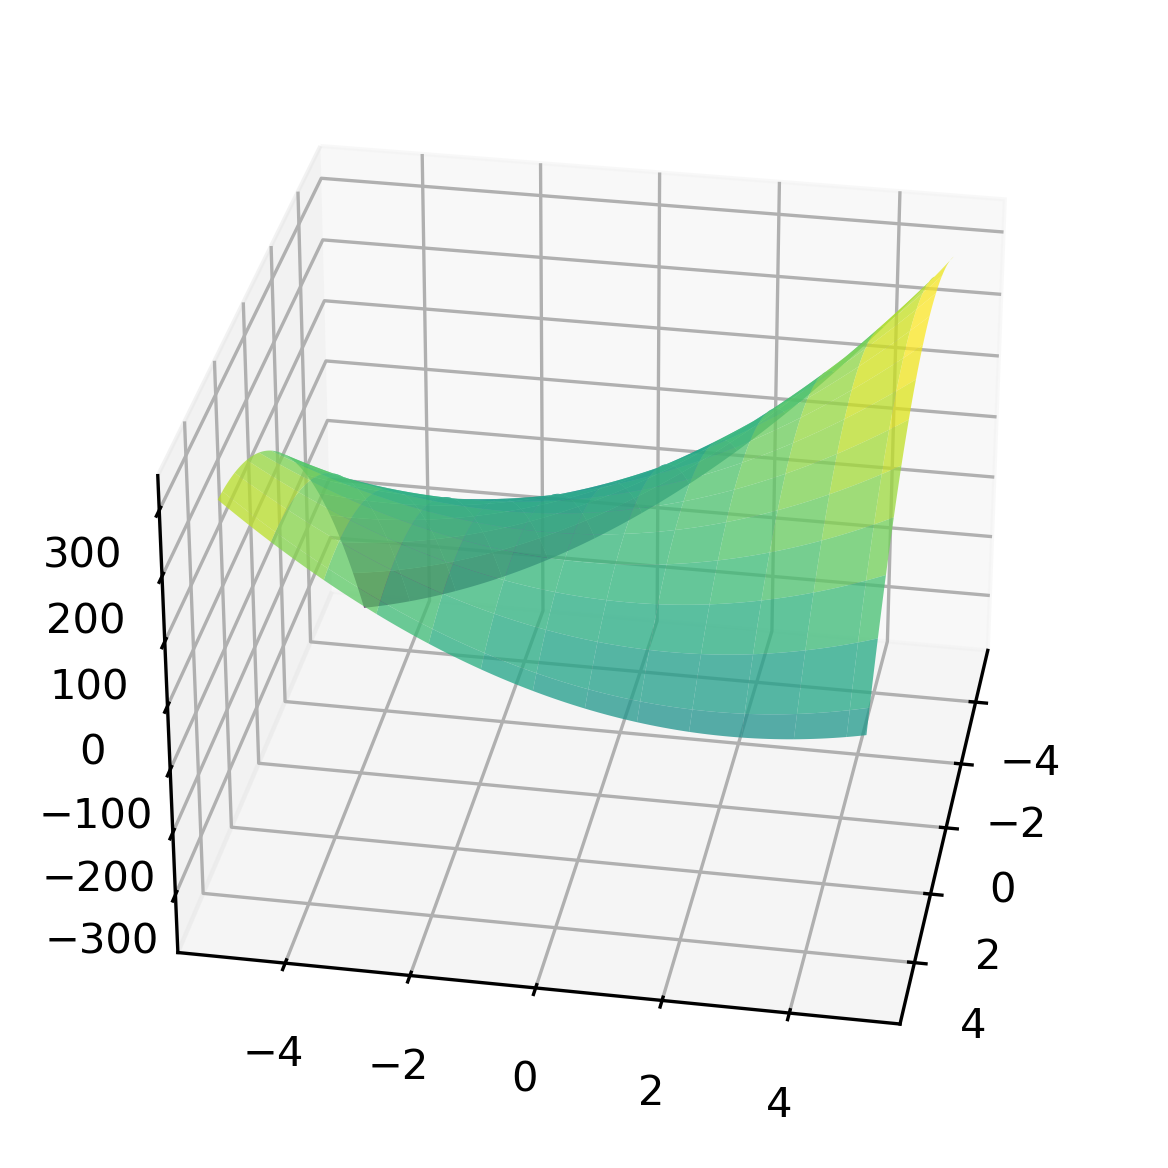

In [20]:
# Modelo BB

# Modelo CCD
from scipy.optimize import minimize

# generamos el modelo reducido para cemento basado en el modelo reducido
formula = 'y~'+'+'+ FirstOformula('A_coded', 'B_coded', 'C_coded')+'+'+ SecondOformula('A_coded', 'B_coded', 'C_coded')\
+ '+' + TWIformula('A_coded', 'B_coded', 'C_coded')

ols_bb = ols(formula, data = df_catapulta).fit()

def modelobb(X, params):

    X = cuadratic_model_variables(np.atleast_2d(X))
    return (X @ params)



res = minimize(
    modeloCCD_red, [0,0,0], args = (ols_bb.params.values), method = 'Nelder-Mead',
    # bounds = boundaries
)

print(res) #-2.3532589993841577e+92
# da un resultado incoherente, revisemos la curva de respuesta para entender el sistema

x_lim = np.linspace(-5, 5, 100)
y_lim = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x_lim, y_lim)
Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j] = modelobb(np.array([X[i,j], Y[i,j], 0]), ols_bb.params.values)

fig = plt.figure(dpi = 300)
ax = fig.add_subplot(1,1, 1, projection = '3d')
ax.plot_surface(X, Y, Z, cmap = 'viridis', lw=1, rstride=8, cstride=8,
                alpha=0.75, zorder = 0)
ax.view_init(azim=10)

A partir de esto buscamos los mínimos y máximos dentro de nuestro espacio de diseño, dado a que el punto estacionario es un punto silla.

/var/folders/zv/p838yyl57rb2tlk802d5y2hh0000gn/T/ipykernel_27846/3839205945.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i,j] = modelobb(np.array([X[i,j], Y[i,j], res.x[2]]), ols_bb.params.values)


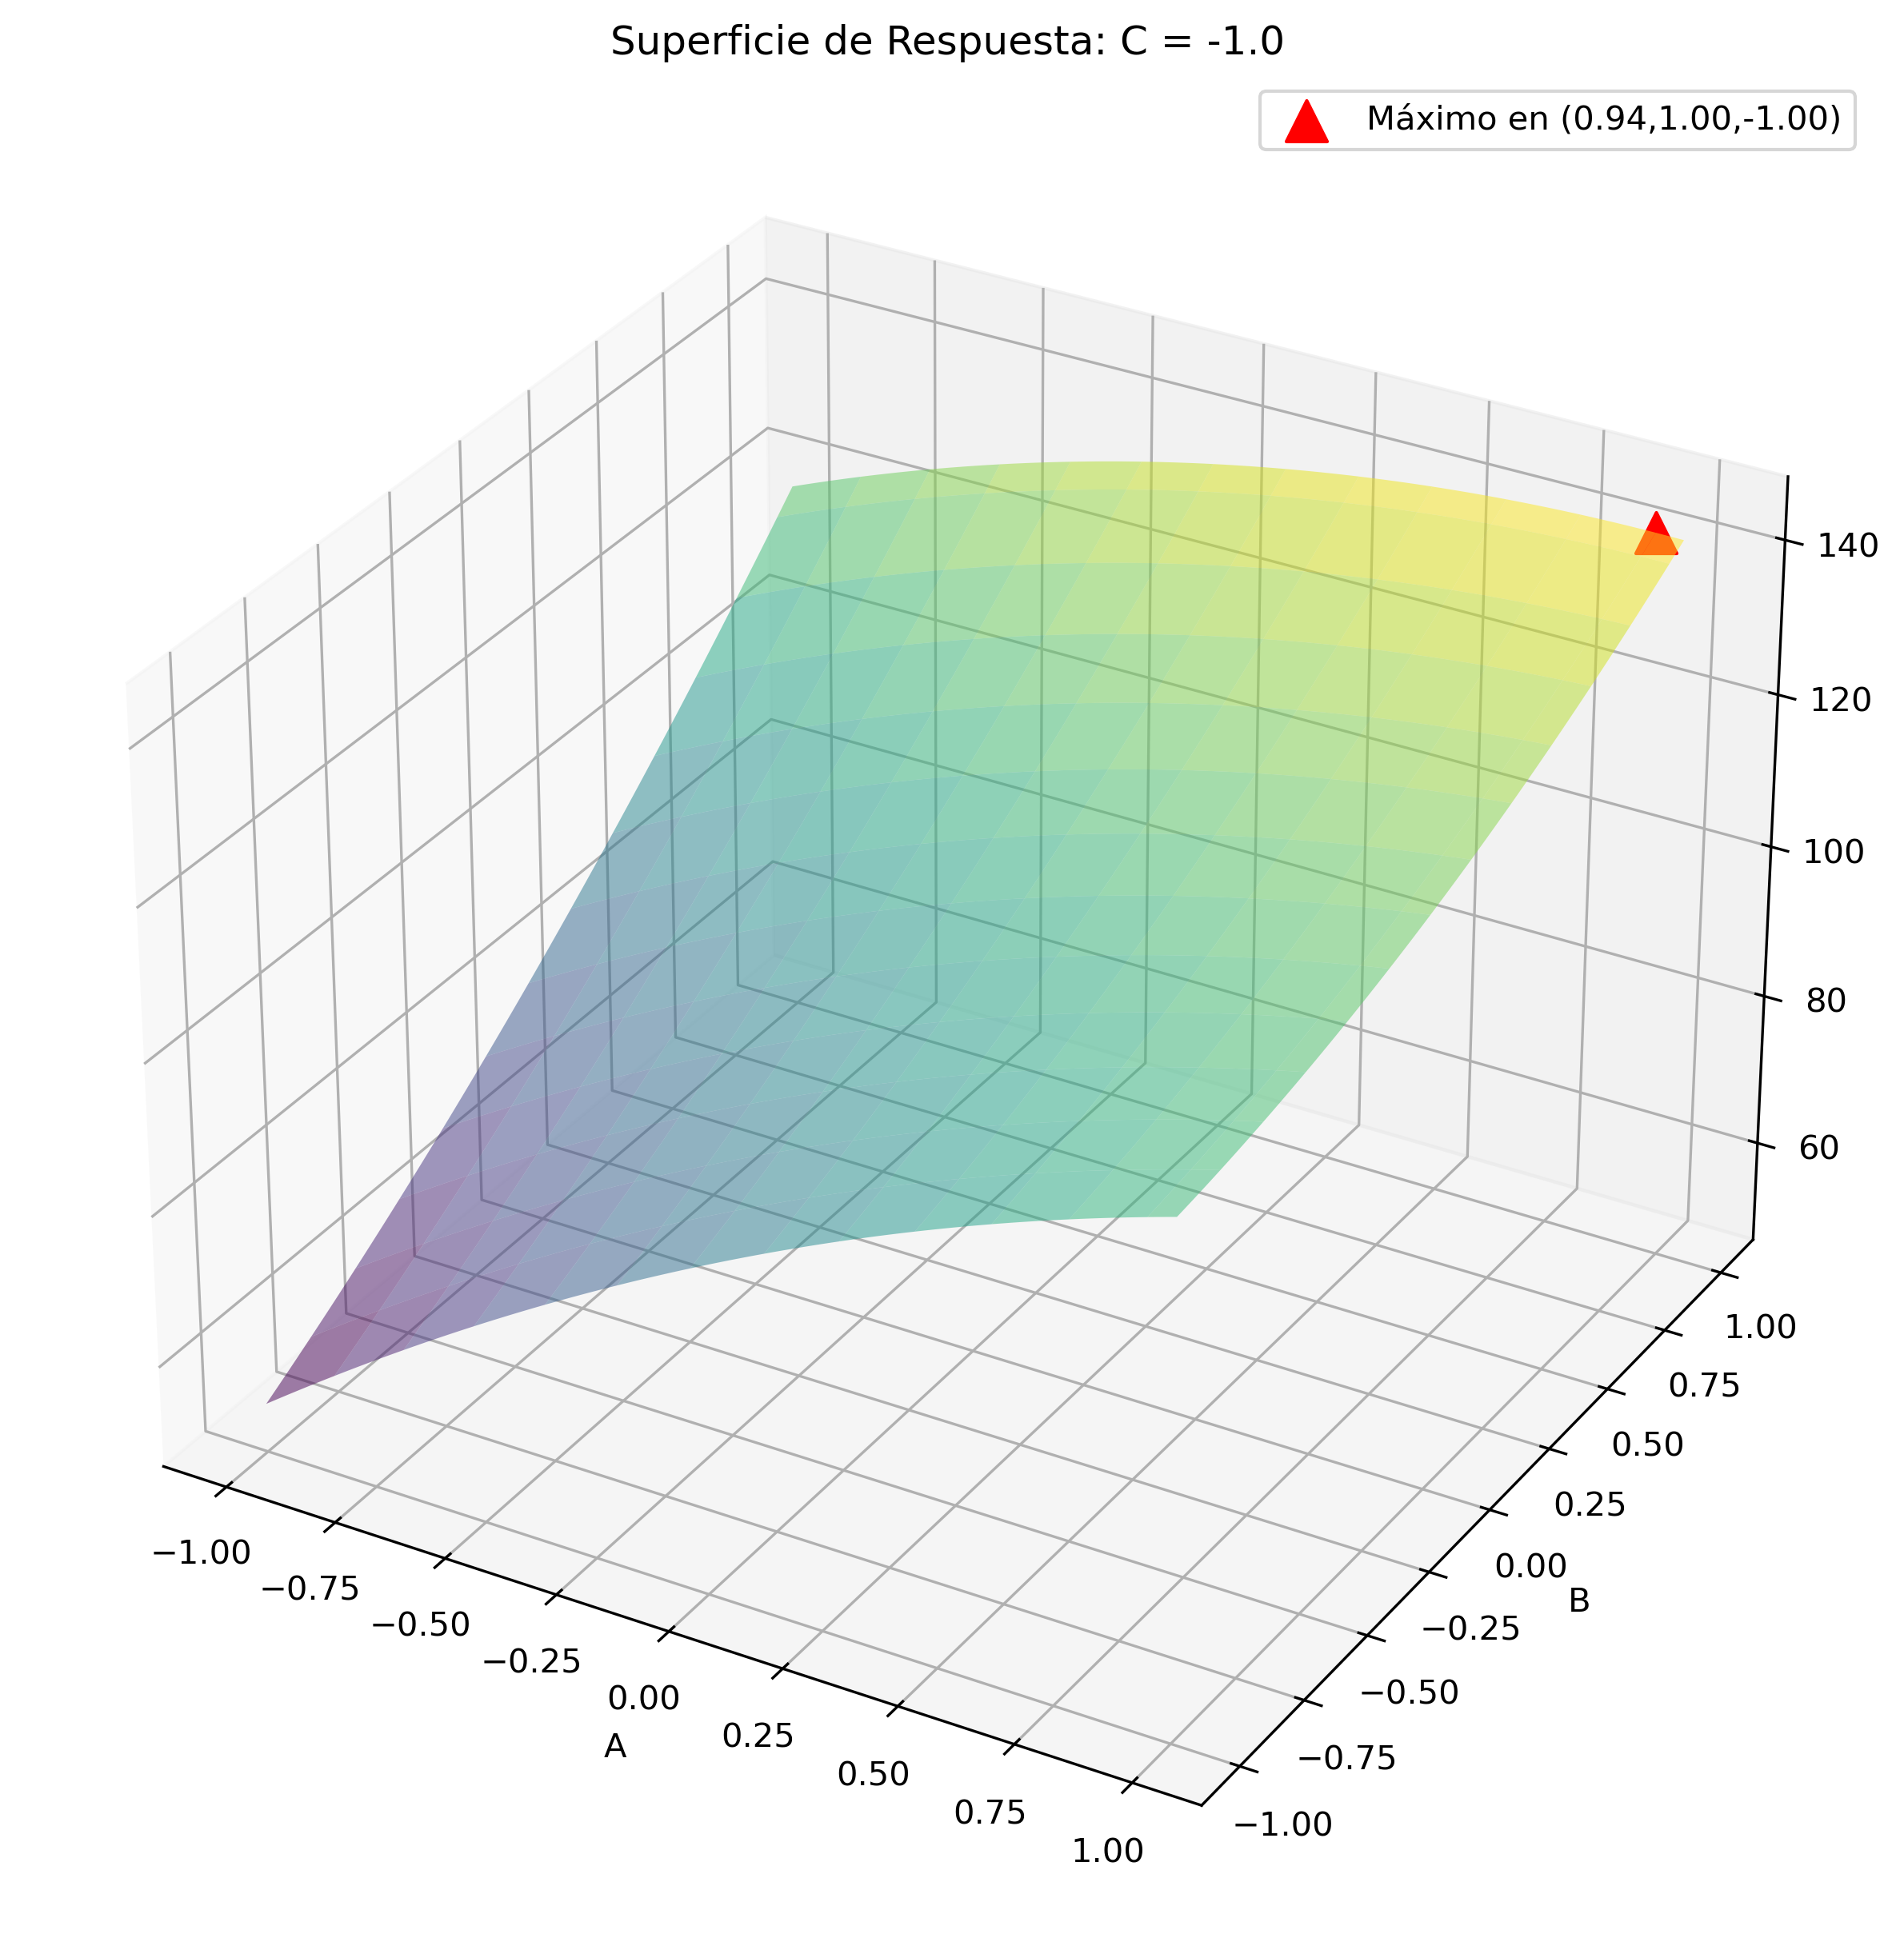

In [21]:
# Modelo BB

# Modelo CCD
from scipy.optimize import minimize

# generamos el modelo reducido para cemento basado en el modelo reducido
formula = 'y~'+'+'+ FirstOformula('A_coded', 'B_coded', 'C_coded')+'+'+ SecondOformula('A_coded', 'B_coded', 'C_coded')\
+ '+' + TWIformula('A_coded', 'B_coded', 'C_coded')

ols_bb = ols(formula, data = df_catapulta).fit()

def rmodelobb(X, params):

    X = cuadratic_model_variables(np.atleast_2d(X))
    return -(X @ params)

boundaries = [
    (np.min(df_catapulta['A_coded']), np.max(df_catapulta['A_coded'])),
    (np.min(df_catapulta['B_coded']), np.max(df_catapulta['B_coded'])),
    (np.min(df_catapulta['C_coded']), np.max(df_catapulta['C_coded']))
]

res = minimize(
    rmodelobb, [0,0,0], args = (ols_bb.params.values),
    bounds = boundaries
)

x_lim = np.linspace(np.min(df_catapulta['A_coded']), np.max(df_catapulta['A_coded']), 100)
y_lim = np.linspace(np.min(df_catapulta['B_coded']), np.max(df_catapulta['B_coded']), 100)
X, Y = np.meshgrid(x_lim, y_lim)
Z = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j] = modelobb(np.array([X[i,j], Y[i,j], res.x[2]]), ols_bb.params.values)

fig = plt.figure(dpi = 300, figsize = (10,10))
ax = fig.add_subplot(1,1, 1, projection = '3d')
ax.plot_surface(X, Y, Z, cmap = 'viridis', lw=1, rstride=8, cstride=8,
                alpha=0.5, zorder = 0)

ax.scatter(res.x[0], res.x[1], modelobb([res.x[0], res.x[1], res.x[2]], ols_bb.params.values),
           label = f'Máximo en ({res.x[0]:.2f},{res.x[1]:.2f},{res.x[2]:.2f})', s = 150, color = 'red', marker = '^')

ax.set_xlabel('A')
ax.set_ylabel('B')
ax.set_title(f'Superficie de Respuesta: C = {res.x[2]}')
ax.legend()


In [22]:
res.fun

-141.64749999999992